In [1]:
import chollaread
import yt
import trident
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/config.py:82: UserWarning: unable to create yt config directory
  warnings.warn("unable to create yt config directory")
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/config.py:127: UserWarning: unable to write new config file
  warnings.warn("unable to write new config file")
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:768: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
ds = chollaread.load('/Users/sofimar/Desktop/Summer Research/146.h5', cell_size_cgs=(10/256)*chollaread.kpc)

yt : [INFO     ] 2021-11-29 14:30:42,607 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-11-29 14:30:42,608 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2021-11-29 14:30:42,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-11-29 14:30:42,609 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22]
yt : [INFO     ] 2021-11-29 14:30:42,610 Parameters: cosmological_simulation   = 0.0


In [3]:
def spec_avg(x0, y0, z0, x, y, z, Nx, Nz,
             line, el, rom_num, lmin, lmax, lrest, gamma, f_value, amu,
             DIY=False, ind_p=True):
    
    # Make array of rays
    k = (3.086E+21)*10 # Code length
    cu = 1/256
    
    arrays = []
    
    
    for i in range(Nx):
        for j in range(Nz):
        
            ray_start = np.array([x0+(i*cu),y0,z0+(j*cu)])*k
            ray_end = np.array([x+(i*cu),y,z+(j*cu)])*k

            ray = trident.make_simple_ray(ds,
                                         start_position=ray_start,
                                         end_position=ray_end,
                                         data_filename= 'ray.h5',
                                         lines='all',
                                         ftype='gas')



            sg = trident.SpectrumGenerator(lambda_min= lmin, lambda_max= lmax, dlambda=0.01)
            
            if DIY==False:
            
                sg.make_spectrum(ray, lines=[line])
                sg.save_spectrum('spec.txt')
                
            else:
                sg.add_line_to_database(el, rom_num, lrest, gamma,f_value, field=None, identifier=line)

                sg.make_spectrum(ray, lines=[line])
                sg.save_spectrum('spec.txt')

            f = np.loadtxt('spec.txt')
            lam = f[:,0] # All rows, 1st column
            flux = f[:,2]

            tog = np.array([lam, flux])
            arrays.append(tog)
        
  
    
    # Average Flux
    flux_list = []
    avg = []

    for n in range(Nx*Nz): # N = Nx * Nz     
        flux_ = arrays[n][1]
        flux_list.append(flux_) # Append flux to a list
        flux_arr = np.array(flux_list) # Turn list into an array
        flux_a = flux_arr.T # Transpose array
        
    for m in range(len(flux_a)):
        avg_ = np.average(flux_a[m])
        avg.append(avg_)
        
    fig = plt.figure(figsize=(15, 5))
    
    if ind_p==True:
        for p in range(Nx*Nz):
            plt.plot(arrays[0][0], arrays[p][1], alpha=0.5)
    else:
        pass
    plt.plot(arrays[0][0], avg, color='black', label = "Average Spectrum", linewidth=1.75)
    plt.xlim(lmin, lmax)
    plt.title(line)
    plt.legend(fontsize='large')
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Flux')
    
    return arrays[0][0], avg
    

In [4]:
def make_ray(x0, y0, z0, x, y, z):
    
    k = (3.086E+21)*10 # Code length
    
    ray_start = np.array([x0,y0,z0])*k
    ray_end = np.array([x,y,z])*k
    
    ray = trident.make_simple_ray(ds,
                                 start_position=ray_start,
                                 end_position=ray_end,
                                 data_filename= 'ray_.h5',
                                 lines='all',
                                 ftype='gas')
    return ray

In [5]:
def slicep(direction):

    sl = yt.SlicePlot(ds, direction, [("density")])
    sl.annotate_ray(ray_, arrow=True)
    sl.annotate_ray(ray_2, arrow=True)
    sl.annotate_ray(ray_3, arrow=True)
    sl.annotate_ray(ray_4, arrow=True)
    sl.set_cmap(("density"), "BLUE-RED")

    sl.show()

In [6]:
def proj(direction, a, b, a2, b2, a3, b3, a4, b4):
    
    px = yt.ProjectionPlot(ds, direction, 'density')
    px.annotate_marker((a,b), coord_system="plot", plot_args={"color":"dimgrey", "s": 150})
    px.annotate_marker((a2,b2), coord_system="plot", plot_args={"color":"black", "s": 150})
    px.annotate_marker((a3,b3), coord_system="plot", plot_args={"color":"dimgrey", "s": 150})
    px.annotate_marker((a4,b4), coord_system="plot", plot_args={"color":"black", "s": 150})
    px.show()

In [7]:
def compare(top_wav, top_flux, bot_wav, bot_flux, line):
    
    plt.figure(figsize=(15,5))

    plt.plot(top_wav, top_flux, label='Top', color='deeppink')
    plt.plot(bot_wav, bot_flux, label='Bottom', color='black')
    plt.title('Average Spectra:'+ line, fontsize=14)
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Flux')
    plt.legend(fontsize='large')

In [55]:
# Projection Plot units to Slice Plot Units
def pts_z(z):
    return(z+5)/10

def pts_x(x):
    return (x+10)/10

# Slice Plot units to Projection Plot units
def stp_z(z):
    return(z*10)-5

def stp_x(x):
    return (x*10)-10

# Number of iterations per variable
def get_N(a0, a):
    return (a-a0)*256

yt : [INFO     ] 2021-11-29 16:26:16,136 Projection completed
yt : [INFO     ] 2021-11-29 16:26:16,137 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:26:16,137 ylim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 16:26:16,139 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:26:16,139 ylim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 16:26:16,141 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fall


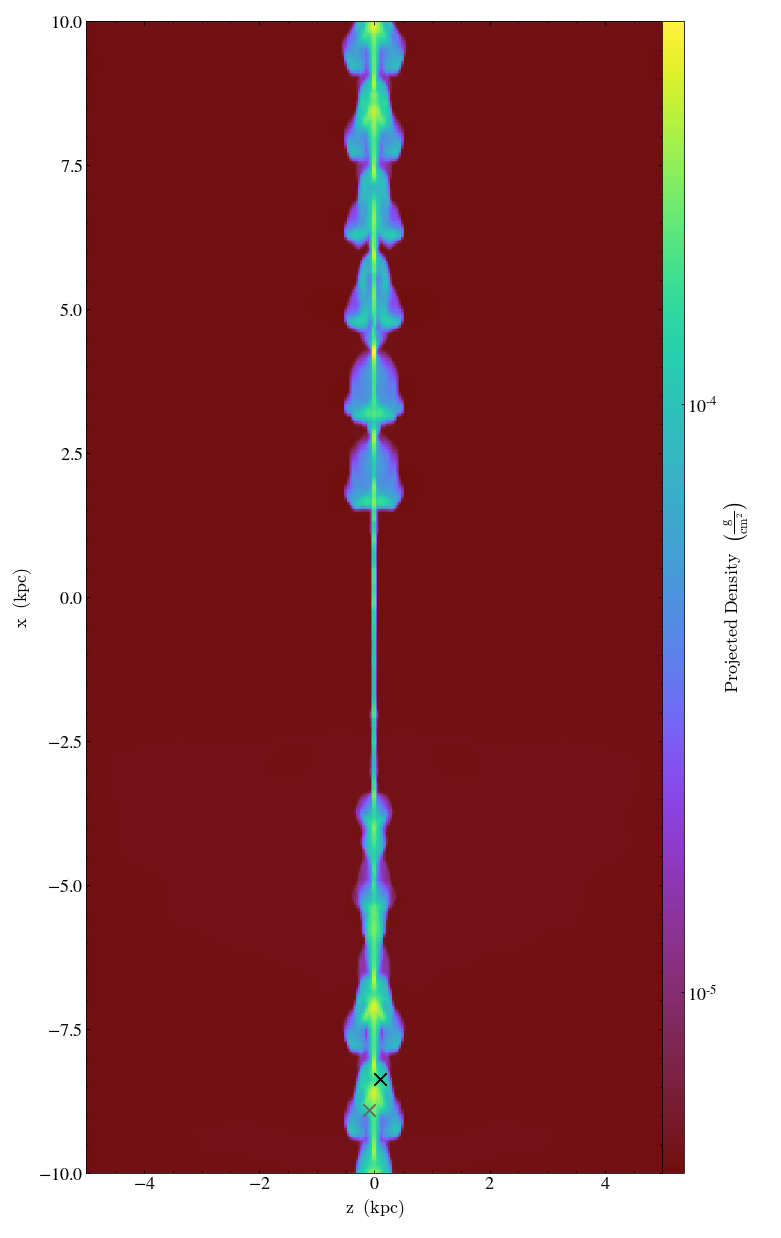

In [54]:
proj('y', -0.1,-8.91,0.1,-8.36,-0.1,-8.91,0.1,-8.36)

In [14]:
# Top Cloud
# Nx = 14
# Nz = 5
ray_ = make_ray(0.109,.618,.49,0.109,.68,.49)
ray_2 = make_ray(0.164,.618,.51,0.165,.68,.51)
# Bottom Cloud
# Nx = 14
# Nz = 5
ray_3 = make_ray(0.109,.27,.49,0.109,.44,.49)
ray_4 = make_ray(0.164,.27,.51,0.165,.44,.51)

yt : [INFO     ] 2021-11-29 14:35:26,714 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:35:26,719 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:35:27,783 Saving field data to yt dataset: ray_.h5.
yt : [INFO     ] 2021-11-29 14:35:27,922 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:35:27,923 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:35:27,924 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:35:27,925 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO    

yt : [INFO     ] 2021-11-29 14:35:44,531 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 14:35:44,531 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 14:35:44,532 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 14:35:44,533 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 14:35:44,534 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/opt/anaconda3/e


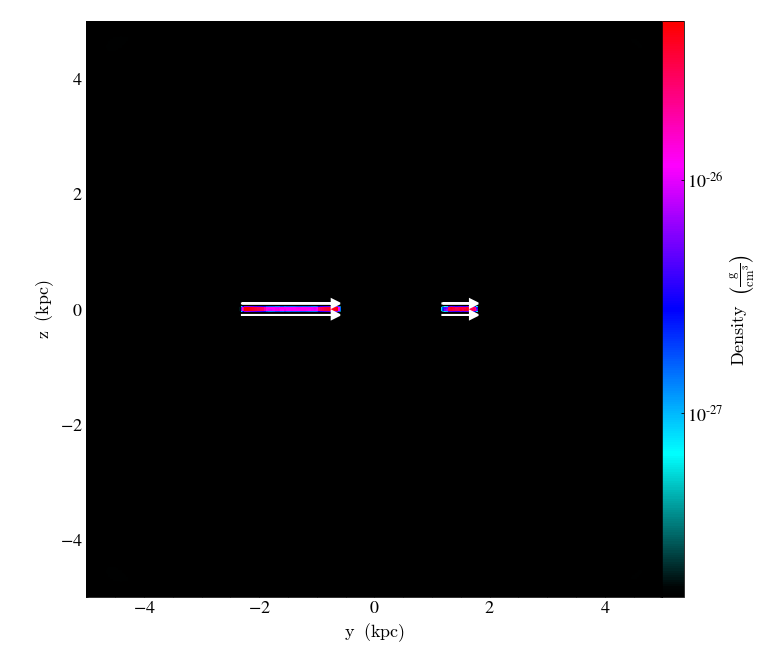

In [15]:
slicep('x')

yt : [INFO     ] 2021-11-29 02:15:20,723 xlim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 02:15:20,724 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 02:15:20,725 xlim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 02:15:20,726 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 02:15:20,727 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for


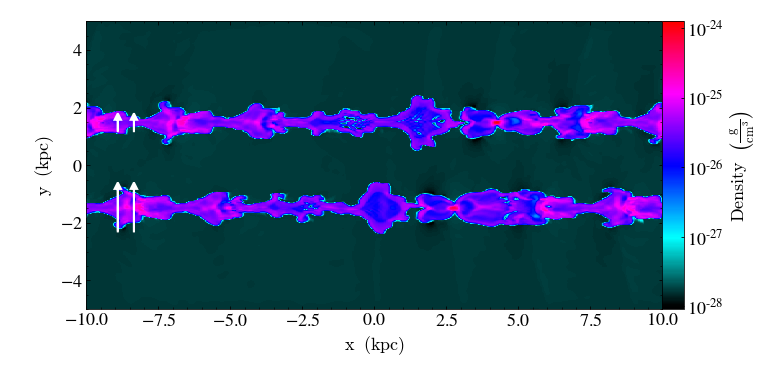

In [14]:
slicep('z')

## C IV

yt : [INFO     ] 2021-11-29 14:40:07,465 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
yt : [INFO     ] 2021-11-29 14:40:07,467 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:40:08,482 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:40:08,604 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:40:08,605 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:40:08,606 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:40:08,607 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:40:08,608 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:40:08,610 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:40:08,624 Allocating for 1

yt : [INFO     ] 2021-11-29 14:40:15,497 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:40:15,623 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:40:15,623 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:40:15,624 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:40:15,625 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:40:15,626 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:40:15,628 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:40:15,643 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:40:15,649 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:40:15,784 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:40:15,790 Creating spectrum
Addi

yt : [INFO     ] 2021-11-29 14:40:23,338 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:40:23,339 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:40:23,340 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:40:23,342 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:40:23,346 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:40:23,368 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:40:23,377 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:40:23,534 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:40:23,540 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3579.66it/s]
yt : [INFO     ] 2021-11-29 14:40:23,608 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-11-29 14:40:31,286 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:40:31,288 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:40:31,291 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:40:31,313 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:40:31,319 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:40:31,519 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:40:31,526 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2891.10it/s]
yt : [INFO     ] 2021-11-29 14:40:31,610 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:40:31,634 Getting segment at z = 0.0: [0.06035937 0.309      0.24695313] unitary to [0.06035937 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:40:31,63

yt : [INFO     ] 2021-11-29 14:40:38,513 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:40:38,526 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:40:38,532 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:40:38,663 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:40:38,669 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2866.69it/s]
yt : [INFO     ] 2021-11-29 14:40:38,731 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:40:38,752 Getting segment at z = 0.0: [0.0623125  0.309      0.24695313] unitary to [0.0623125  0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:40:38,755 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:40:39,754 Saving field dat

yt : [INFO     ] 2021-11-29 14:40:45,778 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:40:45,786 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2840.42it/s]
yt : [INFO     ] 2021-11-29 14:40:45,851 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:40:45,871 Getting segment at z = 0.0: [0.06426562 0.309      0.24695313] unitary to [0.06426562 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:40:45,873 Getting subsegment: [0.06426562499999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.06426562499999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:40:46,891 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:40:47,018 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:40:47,018 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO  

yt : [INFO     ] 2021-11-29 14:40:52,708 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3369.71it/s]
yt : [INFO     ] 2021-11-29 14:40:52,773 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:40:52,793 Getting segment at z = 0.0: [0.06621875 0.309      0.24695313] unitary to [0.06621875 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:40:52,795 Getting subsegment: [0.06621874999999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.06621874999999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:40:53,804 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:40:53,920 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:40:53,920 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:40:53,921 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 4024.79it/s]
yt : [INFO     ] 2021-11-29 14:41:06,789 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:41:06,808 Getting segment at z = 0.0: [0.070125   0.309      0.24695313] unitary to [0.070125   0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:41:06,810 Getting subsegment: [0.07012499999999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.07012499999999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:41:07,807 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:41:07,925 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:41:07,926 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:41:07,927 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:41:07,928 Parameters: domain_right_edge         = [6

yt : [INFO     ] 2021-11-29 14:41:13,801 Getting segment at z = 0.0: [0.07207812 0.309      0.24695313] unitary to [0.07207812 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:41:13,803 Getting subsegment: [0.07207812499999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.07207812499999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:41:14,837 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:41:14,954 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:41:14,955 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:41:14,956 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:41:14,957 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:41:14,958 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:41:14,960 Setting 

yt : [INFO     ] 2021-11-29 14:41:20,746 Getting subsegment: [0.07403125 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.07403125 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:41:21,758 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:41:21,882 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:41:21,883 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:41:21,884 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:41:21,885 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:41:21,886 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:41:21,888 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:41:21,905 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:41:21,911 Identified 

yt : [INFO     ] 2021-11-29 14:41:28,732 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:41:28,856 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:41:28,857 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:41:28,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:41:28,859 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:41:28,860 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:41:28,862 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:41:28,876 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:41:28,884 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:41:29,009 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:41:29,015 Creating spectrum
Addi

yt : [INFO     ] 2021-11-29 14:41:35,876 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:41:35,876 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:41:35,877 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:41:35,878 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:41:35,880 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:41:35,894 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:41:35,901 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:41:36,026 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:41:36,031 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3848.82it/s]
yt : [INFO     ] 2021-11-29 14:41:36,092 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-11-29 14:41:42,890 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:41:42,892 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:41:42,896 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:41:42,913 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:41:42,919 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:41:43,053 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:41:43,059 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3887.43it/s]
yt : [INFO     ] 2021-11-29 14:41:43,122 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:41:43,142 Getting segment at z = 0.0: [0.07989063 0.309      0.24890625] unitary to [0.07989063 0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 14:41:43,14

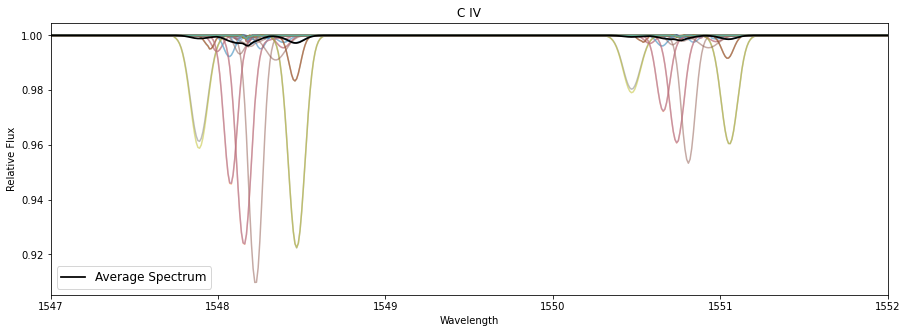

In [18]:
civ_top = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
             'C IV', False, False, 1547, 1552, False, False, False, False,
             DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 14:41:47,539 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:41:47,541 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:41:48,682 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:41:48,801 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:41:48,802 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:41:48,803 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:41:48,804 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 14:41:54,760 Getting segment at z = 0.0: [0.05645312 0.135      0.245     ] unitary to [0.05645312 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 14:41:54,762 Getting subsegment: [0.056453125 unitary, 0.135 unitary, 0.245 unitary] to [0.056453125 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:41:55,786 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:41:55,909 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:41:55,910 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:41:55,911 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:41:55,912 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:41:55,913 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:41:55,915 Setting instrument to Custom
yt : [IN

yt : [INFO     ] 2021-11-29 14:42:02,913 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.245 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:42:03,934 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:42:04,052 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:42:04,052 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:42:04,053 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:42:04,054 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:42:04,055 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:42:04,057 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:42:04,072 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:42:04,079 Identi

yt : [INFO     ] 2021-11-29 14:42:12,767 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:42:12,935 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:42:12,936 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:42:12,937 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:42:12,938 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:42:12,938 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:42:12,940 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:42:12,958 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:42:12,965 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:42:13,149 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:42:13,157 Creating spectrum
Addi

yt : [INFO     ] 2021-11-29 14:42:20,080 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:42:20,081 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:42:20,081 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:42:20,082 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:42:20,084 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:42:20,098 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:42:20,104 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:42:20,225 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:42:20,230 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3518.91it/s]
yt : [INFO     ] 2021-11-29 14:42:20,305 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-11-29 14:42:27,069 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:42:27,070 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:42:27,073 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:42:27,088 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:42:27,094 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:42:27,212 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:42:27,217 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3673.06it/s]
yt : [INFO     ] 2021-11-29 14:42:27,290 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:42:27,309 Getting segment at z = 0.0: [0.06426562 0.135      0.24695313] unitary to [0.06426562 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:42:27,31

yt : [INFO     ] 2021-11-29 14:42:34,302 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:42:34,304 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:42:34,318 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:42:34,324 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:42:34,468 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:42:34,474 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3451.78it/s]
yt : [INFO     ] 2021-11-29 14:42:34,554 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:42:34,573 Getting segment at z = 0.0: [0.06621875 0.135      0.24695313] unitary to [0.06621875 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:42:34,575 Getting subsegment: [0.06621874999999999 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.06621874999999999 unita

yt : [INFO     ] 2021-11-29 14:42:41,335 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:42:41,349 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:42:41,354 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:42:41,479 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:42:41,484 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3336.58it/s]
yt : [INFO     ] 2021-11-29 14:42:41,561 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:42:41,581 Getting segment at z = 0.0: [0.06817188 0.135      0.24695313] unitary to [0.06817188 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:42:41,583 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:42:42,6

yt : [INFO     ] 2021-11-29 14:42:48,412 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:42:48,540 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:42:48,545 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3570.86it/s]
yt : [INFO     ] 2021-11-29 14:42:48,621 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:42:48,641 Getting segment at z = 0.0: [0.070125   0.135      0.24695313] unitary to [0.070125   0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:42:48,643 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:42:49,646 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:42:49,764 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 20

yt : [INFO     ] 2021-11-29 14:42:55,554 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:42:55,562 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 4230.36it/s]
yt : [INFO     ] 2021-11-29 14:42:55,632 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:42:55,652 Getting segment at z = 0.0: [0.07207812 0.135      0.24695313] unitary to [0.07207812 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:42:55,654 Getting subsegment: [0.07207812499999999 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.07207812499999999 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:42:56,759 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:42:56,936 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:42:56,937 Parameters: domain_dimensions         = [2 2 

yt : [INFO     ] 2021-11-29 14:43:02,610 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2960.56it/s]
yt : [INFO     ] 2021-11-29 14:43:02,687 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:43:02,707 Getting segment at z = 0.0: [0.07403125 0.135      0.24695313] unitary to [0.07403125 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:43:02,709 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:43:03,698 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:43:03,818 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:43:03,820 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:43:03,820 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3309.53it/s]
yt : [INFO     ] 2021-11-29 14:43:16,658 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:43:16,676 Getting segment at z = 0.0: [0.0779375  0.135      0.24695313] unitary to [0.0779375  0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:43:16,678 Getting subsegment: [0.07793749999999999 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.07793749999999999 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:43:17,673 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:43:17,782 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:43:17,783 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:43:17,784 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:43:17,785 Parameters: domain_right_ed

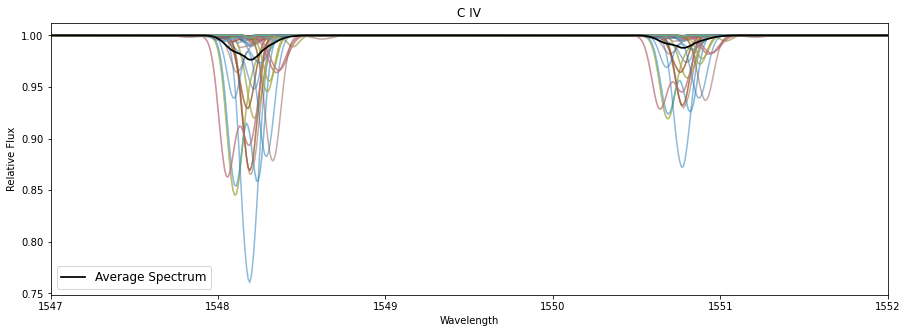

In [19]:
civ_bot = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
             'C IV', False, False, 1547, 1552, False, False, False, False,
             DIY=False, ind_p=True)

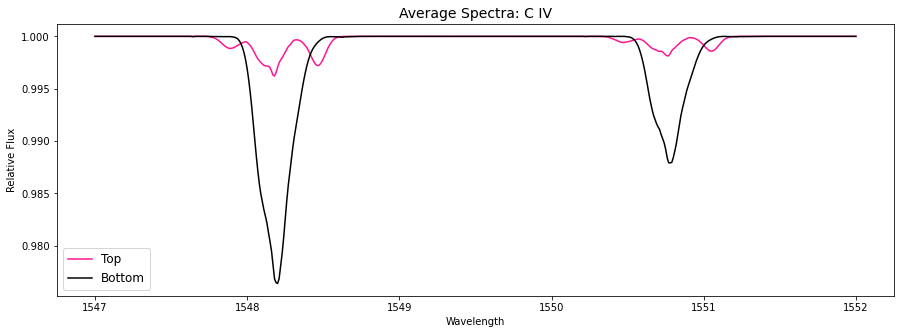

In [20]:
compare(civ_top[0], civ_top[1], civ_bot[0], civ_bot[1], ' C IV')

## Ly a

yt : [INFO     ] 2021-11-29 14:43:30,217 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:43:30,220 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:43:31,251 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:43:31,360 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:43:31,361 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:43:31,362 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:43:31,363 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 14:43:37,753 Getting subsegment: [0.056453125 unitary, 0.309 unitary, 0.245 unitary] to [0.056453125 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:43:38,759 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:43:38,890 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:43:38,891 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:43:38,892 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:43:38,893 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:43:38,894 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:43:38,896 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:43:38,911 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:43:38,917 Identified 2.500e+01 octs
yt : [INFO 

yt : [INFO     ] 2021-11-29 14:43:46,555 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:43:46,684 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:43:46,685 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:43:46,685 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:43:46,686 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:43:46,687 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:43:46,690 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:43:46,705 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:43:46,712 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:43:46,940 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:43:46,947 Creating spectrum
Adding 

yt : [INFO     ] 2021-11-29 14:43:55,990 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:43:55,992 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:43:55,993 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:43:55,994 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:43:55,995 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:43:55,997 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:43:56,016 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:43:56,025 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:43:56,363 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:43:56,372 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 230.51it/s]
yt

yt : [INFO     ] 2021-11-29 14:44:05,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:44:05,691 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:44:05,692 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:44:05,694 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:44:05,712 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:44:05,719 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:44:05,927 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:44:05,934 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 209.66it/s]
yt : [INFO     ] 2021-11-29 14:44:06,090 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:44:06,091 Writing spectrum to ascii file: s

yt : [INFO     ] 2021-11-29 14:44:14,620 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:44:14,622 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:44:14,636 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:44:14,642 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:44:14,779 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:44:14,785 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 244.74it/s]
yt : [INFO     ] 2021-11-29 14:44:14,908 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:44:14,909 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:44:14,968 Getting segment at z = 0.0: [0.06426562 0.309      0.24695313] unitary to [0.06426562 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:44:14,970 Getting subsegment: 

yt : [INFO     ] 2021-11-29 14:44:22,627 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:44:22,641 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:44:22,648 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:44:22,787 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:44:22,793 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 241.40it/s]
yt : [INFO     ] 2021-11-29 14:44:22,922 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:44:22,923 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:44:22,986 Getting segment at z = 0.0: [0.06621875 0.309      0.24695313] unitary to [0.06621875 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:44:22,988 Getting subsegment: [0.06621874999999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.06621

yt : [INFO     ] 2021-11-29 14:44:30,914 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:44:30,919 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:44:31,059 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:44:31,064 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 177.66it/s]
yt : [INFO     ] 2021-11-29 14:44:31,238 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:44:31,239 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:44:31,316 Getting segment at z = 0.0: [0.06817188 0.309      0.24695313] unitary to [0.06817188 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:44:31,320 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.068171875 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 202

yt : [INFO     ] 2021-11-29 14:44:39,875 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:44:39,880 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 259.32it/s]
yt : [INFO     ] 2021-11-29 14:44:40,004 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:44:40,005 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:44:40,066 Getting segment at z = 0.0: [0.070125   0.309      0.24695313] unitary to [0.070125   0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:44:40,068 Getting subsegment: [0.07012499999999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.07012499999999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:44:41,120 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:44:41,243 Parameters: current_time              = 0.0 code_tim

yt : [INFO     ] 2021-11-29 14:44:47,891 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 194.76it/s]
yt : [INFO     ] 2021-11-29 14:44:48,044 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:44:48,044 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:44:48,112 Getting segment at z = 0.0: [0.07207812 0.309      0.24695313] unitary to [0.07207812 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:44:48,116 Getting subsegment: [0.07207812499999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.07207812499999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:44:49,246 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:44:49,367 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:44:49,368 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-

yt : [INFO     ] 2021-11-29 14:45:05,912 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:45:05,981 Getting segment at z = 0.0: [0.07598437 0.309      0.24695313] unitary to [0.07598437 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:45:05,984 Getting subsegment: [0.07598437499999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.07598437499999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:45:07,283 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:45:07,400 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:45:07,401 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:45:07,401 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:45:07,402 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:45:07,403 Parameters

yt : [INFO     ] 2021-11-29 14:45:14,491 Getting segment at z = 0.0: [0.0779375  0.309      0.24695313] unitary to [0.0779375  0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:45:14,493 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.07793749999999999 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:45:15,558 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:45:15,673 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:45:15,674 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:45:15,675 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:45:15,675 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:45:15,676 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:45:15,678 Setting 

yt : [INFO     ] 2021-11-29 14:45:22,577 Getting subsegment: [0.079890625 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.079890625 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:45:23,659 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:45:23,778 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:45:23,779 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:45:23,779 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:45:23,780 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:45:23,781 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:45:23,783 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:45:23,801 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:45:23,807 Identifie

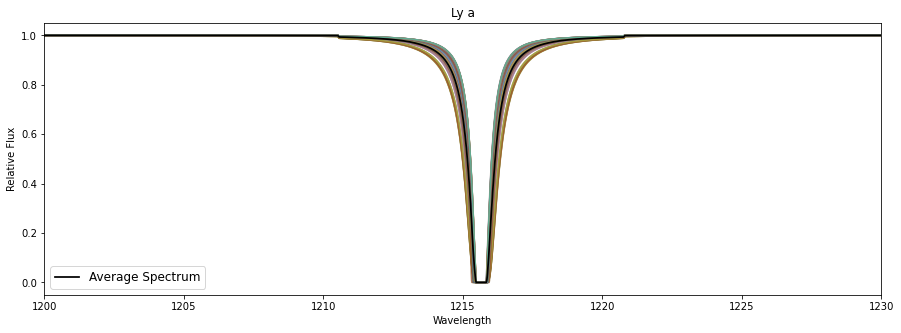

In [21]:
lya_top = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
             'Ly a', False, False, 1200, 1230, False, False, False, False,
             DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 14:45:29,812 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:45:29,816 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:45:31,019 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:45:31,187 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:45:31,188 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:45:31,189 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:45:31,190 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 14:45:39,742 Getting segment at z = 0.0: [0.05645312 0.135      0.245     ] unitary to [0.05645312 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 14:45:39,744 Getting subsegment: [0.056453125 unitary, 0.135 unitary, 0.245 unitary] to [0.056453125 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:45:40,837 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:45:40,962 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:45:40,963 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:45:40,964 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:45:40,965 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:45:40,965 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:45:40,967 Setting instrument to Custom
yt : [IN

yt : [INFO     ] 2021-11-29 14:45:49,192 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.245 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:45:50,447 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:45:50,642 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:45:50,643 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:45:50,644 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:45:50,645 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:45:50,646 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:45:50,648 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:45:50,670 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:45:50,680 Identi

yt : [INFO     ] 2021-11-29 14:45:59,485 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.245 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:46:00,712 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:46:00,841 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:46:00,842 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:46:00,843 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:46:00,844 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:46:00,845 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:46:00,848 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:46:00,865 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:46:00,874 Identified 4.100e+01 o

yt : [INFO     ] 2021-11-29 14:46:09,378 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:46:09,495 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:46:09,496 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:46:09,497 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:46:09,498 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:46:09,498 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:46:09,501 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:46:09,515 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:46:09,522 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:46:09,655 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:46:09,663 Creating spectrum
Adding 

yt : [INFO     ] 2021-11-29 14:46:19,333 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:46:19,334 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:46:19,334 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:46:19,335 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:46:19,336 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:46:19,338 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:46:19,354 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:46:19,363 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:46:19,513 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:46:19,521 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 162.97it/s]
yt

yt : [INFO     ] 2021-11-29 14:46:29,083 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:46:29,084 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:46:29,084 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:46:29,085 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:46:29,086 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:46:29,088 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:46:29,103 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:46:29,109 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:46:29,245 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:46:29,253 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 137.96it/s]
yt

yt : [INFO     ] 2021-11-29 14:46:38,854 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:46:38,855 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:46:38,856 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:46:38,857 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:46:38,858 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:46:38,860 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:46:38,876 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:46:38,883 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:46:39,171 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:46:39,179 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 172.62it/s]
yt

yt : [INFO     ] 2021-11-29 14:46:47,558 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:46:47,559 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:46:47,559 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:46:47,560 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:46:47,562 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:46:47,576 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:46:47,582 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:46:47,707 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:46:47,714 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 165.12it/s]
yt : [INFO     ] 2021-11-29 14:46:48,036 Not adding continuum Ly C: insufficient column density o

yt : [INFO     ] 2021-11-29 14:46:56,145 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:46:56,146 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:46:56,147 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:46:56,148 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:46:56,150 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:46:56,164 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:46:56,169 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:46:56,297 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:46:56,303 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 185.23it/s]
yt : [INFO     ] 2021-11-29 14:46:56,592 Not adding continuum Ly C: insufficient column density o

yt : [INFO     ] 2021-11-29 14:47:05,244 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:47:05,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:47:05,246 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:47:05,247 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:47:05,249 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:47:05,264 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:47:05,271 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:47:05,425 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:47:05,432 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 198.90it/s]
yt : [INFO     ] 2021-11-29 14:47:05,710 Not adding continuum Ly C: insufficient column density o

yt : [INFO     ] 2021-11-29 14:47:14,387 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:47:14,388 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:47:14,389 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:47:14,391 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:47:14,404 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:47:14,410 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:47:14,545 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:47:14,671 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 238.18it/s]
yt : [INFO     ] 2021-11-29 14:47:14,913 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:47:14,913 Writing spectrum to ascii file: s

yt : [INFO     ] 2021-11-29 14:47:23,434 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:47:23,435 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:47:23,436 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:47:23,438 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:47:23,454 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:47:23,459 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:47:23,583 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:47:23,589 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 251.30it/s]
yt : [INFO     ] 2021-11-29 14:47:23,811 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:47:23,811 Writing spectrum to ascii file: s

yt : [INFO     ] 2021-11-29 14:47:31,527 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:47:31,528 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:47:31,529 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:47:31,531 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:47:31,545 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:47:31,551 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:47:31,672 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:47:31,679 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 291.29it/s]
yt : [INFO     ] 2021-11-29 14:47:31,879 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 14:47:31,880 Writing spectrum to ascii file: s

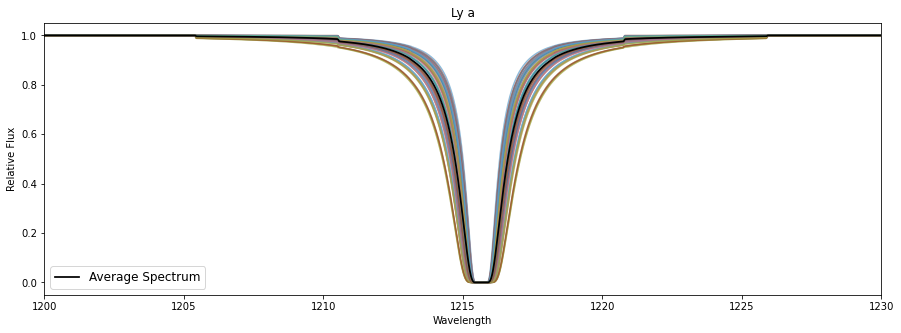

In [22]:
lya_bottom = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
             'Ly a', False, False, 1200, 1230, False, False, False, False,
             DIY=False, ind_p=True)

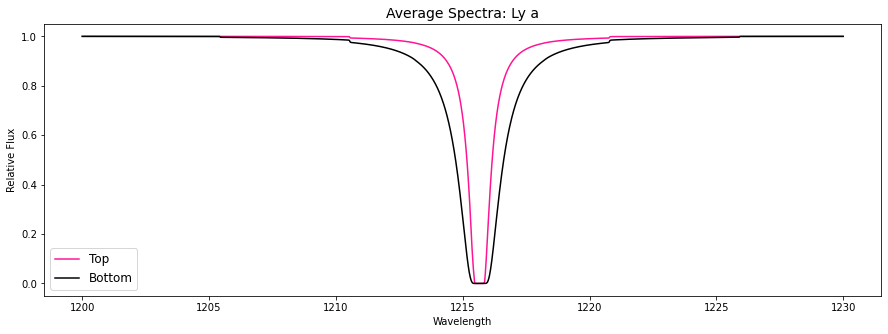

In [23]:
compare(lya_top[0], lya_top[1], lya_bottom[0], lya_bottom[1], ' Ly a')

## O I 1302

yt : [INFO     ] 2021-11-29 14:50:21,150 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:50:21,153 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:50:22,241 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:50:22,364 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:50:22,365 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:50:22,366 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:50:22,367 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 14:50:29,709 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:50:29,710 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:50:29,711 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:50:29,713 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:50:29,727 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:50:29,732 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:50:29,890 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:50:29,896 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2153.26it/s]
yt : [INFO     ] 2021-11-29 14:50:29,960 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:50:29,973 Getting segment at z = 0.0: [0.05645312 0.309      0.2469

yt : [INFO     ] 2021-11-29 14:50:37,017 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1654.67it/s]
yt : [INFO     ] 2021-11-29 14:50:37,082 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:50:37,095 Getting segment at z = 0.0: [0.05840625 0.309      0.24695313] unitary to [0.05840625 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:50:37,098 Getting subsegment: [0.05840625000000001 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:50:38,110 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:50:38,229 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:50:38,230 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:50:38,230 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-

yt : [INFO     ] 2021-11-29 14:50:45,242 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:50:45,243 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:50:45,244 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:50:45,245 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:50:45,246 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:50:45,248 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:50:45,265 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:50:45,271 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:50:45,406 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:50:45,411 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1295.74it/

yt : [INFO     ] 2021-11-29 14:50:52,285 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:50:52,290 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1293.55it/s]
yt : [INFO     ] 2021-11-29 14:50:52,355 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:50:52,369 Getting segment at z = 0.0: [0.0623125  0.309      0.24890625] unitary to [0.0623125  0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 14:50:52,371 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 14:50:53,374 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:50:53,497 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:50:53,498 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:50:53,499 Parameters: d

yt : [INFO     ] 2021-11-29 14:51:00,364 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:51:00,478 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:51:00,479 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:51:00,480 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:51:00,481 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:51:00,482 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:51:00,484 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:51:00,503 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:51:00,509 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:51:00,640 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:51:00,645 Creating spectrum
Adding 

yt : [INFO     ] 2021-11-29 14:51:07,993 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:51:08,001 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:51:08,230 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:51:08,237 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 792.98it/s]
yt : [INFO     ] 2021-11-29 14:51:08,335 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:51:08,355 Getting segment at z = 0.0: [0.06621875 0.309      0.25085937] unitary to [0.06621875 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 14:51:08,358 Getting subsegment: [0.06621874999999999 unitary, 0.309 unitary, 0.250859375 unitary] to [0.06621874999999999 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 14:51:09,710 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:51:09,919 Param

yt : [INFO     ] 2021-11-29 14:51:17,218 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 14:51:18,503 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:51:18,697 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:51:18,698 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:51:18,699 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:51:18,700 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:51:18,701 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:51:18,704 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:51:18,726 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:51:18,734 Identified 2.500e+01 octs

yt : [INFO     ] 2021-11-29 14:51:26,815 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:51:26,817 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:51:26,830 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:51:26,836 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:51:26,970 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:51:26,976 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1360.46it/s]
yt : [INFO     ] 2021-11-29 14:51:27,040 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:51:27,053 Getting segment at z = 0.0: [0.070125  0.309     0.2528125] unitary to [0.070125  0.34      0.2528125] unitary.
yt : [INFO     ] 2021-11-29 14:51:27,055 Getting subsegment: [0.07012499999999999 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07012499999999999 unitary, 0.34 unitary, 0.

yt : [INFO     ] 2021-11-29 14:51:42,834 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:51:42,835 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:51:42,836 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:51:42,836 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:51:42,838 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:51:42,854 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:51:42,861 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:51:42,989 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:51:42,994 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2197.87it/s]
yt : [INFO     ] 2021-11-29 14:51:43,053 Writing spectrum to ascii file: spec.txt.
yt : [INF

yt : [INFO     ] 2021-11-29 14:51:50,172 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:51:50,178 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2238.86it/s]
yt : [INFO     ] 2021-11-29 14:51:50,244 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:51:50,258 Getting segment at z = 0.0: [0.0779375 0.309     0.245    ] unitary to [0.0779375 0.34      0.245    ] unitary.
yt : [INFO     ] 2021-11-29 14:51:50,261 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.245 unitary] to [0.07793749999999999 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:51:51,506 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:51:51,632 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:51:51,632 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:51:51,633 Parameter

yt : [INFO     ] 2021-11-29 14:51:59,555 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:51:59,676 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:51:59,677 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:51:59,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:51:59,679 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:51:59,680 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:51:59,682 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:51:59,697 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:51:59,703 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:51:59,835 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:51:59,840 Creating spectrum
Adding 

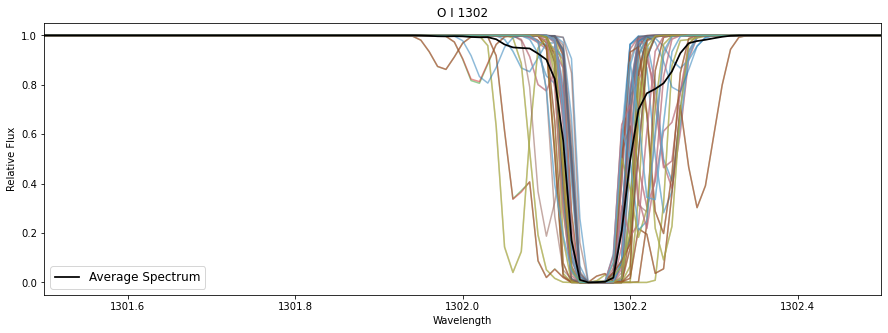

In [24]:
oi1302_t = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
                   'O I 1302', False, False, 1301.5, 1302.5,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 14:52:07,584 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:52:07,587 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:52:08,794 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:52:08,930 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:52:08,931 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:52:08,932 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:52:08,933 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 14:52:17,605 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:52:17,606 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:52:17,607 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:52:17,608 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:52:17,611 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:52:17,626 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:52:17,633 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:52:17,912 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:52:17,920 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1437.02it/s]
yt : [INFO     ] 2021-11-29 14:52:18,005 Writing spectrum to ascii file: spec.txt.
yt : [INF

yt : [INFO     ] 2021-11-29 14:52:26,284 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:52:26,448 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:52:26,455 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1409.61it/s]
yt : [INFO     ] 2021-11-29 14:52:26,549 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:52:26,568 Getting segment at z = 0.0: [0.05840625 0.135      0.24695313] unitary to [0.05840625 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:52:26,571 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:52:27,635 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:52:27,745 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-1

yt : [INFO     ] 2021-11-29 14:52:34,631 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:52:35,748 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:52:35,871 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:52:35,872 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:52:35,873 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:52:35,874 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:52:35,875 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:52:35,877 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:52:35,893 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:52:3

yt : [INFO     ] 2021-11-29 14:52:43,582 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:52:43,584 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:52:43,598 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:52:43,604 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:52:43,725 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:52:43,730 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1644.36it/s]
yt : [INFO     ] 2021-11-29 14:52:43,807 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:52:43,822 Getting segment at z = 0.0: [0.0623125  0.135      0.24890625] unitary to [0.0623125  0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 14:52:43,824 Getting subsegment: [0.0623125 unitary, 0.135 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.22000000000000003 unitary, 

yt : [INFO     ] 2021-11-29 14:53:01,687 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:53:01,866 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:53:01,867 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:53:01,868 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:53:01,869 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:53:01,870 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:53:01,873 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:53:01,894 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:53:01,903 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:53:02,111 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:53:02,121 Creating spectrum
Adding 

yt : [INFO     ] 2021-11-29 14:53:10,216 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:53:10,231 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:53:10,237 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:53:10,382 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:53:10,388 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1629.75it/s]
yt : [INFO     ] 2021-11-29 14:53:10,473 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:53:10,489 Getting segment at z = 0.0: [0.06817188 0.135      0.25085937] unitary to [0.06817188 0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 14:53:10,491 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 14:53:11,603 Saving field data

yt : [INFO     ] 2021-11-29 14:53:18,412 Getting segment at z = 0.0: [0.070125   0.135      0.25085937] unitary to [0.070125   0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 14:53:18,414 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.250859375 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 14:53:19,507 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:53:19,622 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:53:19,623 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:53:19,623 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:53:19,624 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:53:19,625 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:53:19,628 Setting i

yt : [INFO     ] 2021-11-29 14:53:27,321 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:53:27,322 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:53:27,323 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:53:27,323 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:53:27,326 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:53:27,343 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:53:27,350 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:53:27,518 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:53:27,524 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1703.65it/s]
yt : [INFO     ] 2021-11-29 14:53:27,603 Writing spectrum to ascii file: spec.txt.
yt : [INF

yt : [INFO     ] 2021-11-29 14:53:35,356 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:53:35,534 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:53:35,541 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1508.82it/s]
yt : [INFO     ] 2021-11-29 14:53:35,629 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:53:35,645 Getting segment at z = 0.0: [0.07403125 0.135      0.2528125 ] unitary to [0.07403125 0.22       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 14:53:35,647 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 14:53:36,913 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:53:37,087 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:53:37,088 Parameters: domain_d

yt : [INFO     ] 2021-11-29 14:53:43,779 Getting subsegment: [0.07598437499999999 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07598437499999999 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 14:53:44,866 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:53:44,982 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:53:44,983 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:53:44,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:53:44,985 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:53:44,986 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:53:44,988 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:53:45,002 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:53:45,00

yt : [INFO     ] 2021-11-29 14:53:53,042 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:53:53,043 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:53:53,046 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:53:53,067 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:53:53,075 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:53:53,250 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:53:53,255 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1802.26it/s]
yt : [INFO     ] 2021-11-29 14:53:53,329 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:53:53,347 Getting segment at z = 0.0: [0.07989063 0.135      0.245     ] unitary to [0.07989063 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 14:53:53,350 Ge

Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1617.35it/s]
yt : [INFO     ] 2021-11-29 14:54:02,208 Writing spectrum to ascii file: spec.txt.


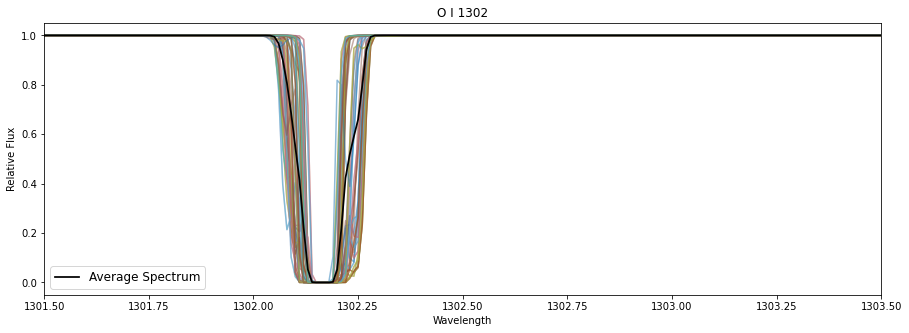

In [25]:
oi1302_b = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
                   'O I 1302', False, False, 1301.5, 1303.5,
                   False, False, False, False, DIY=False, ind_p=True)

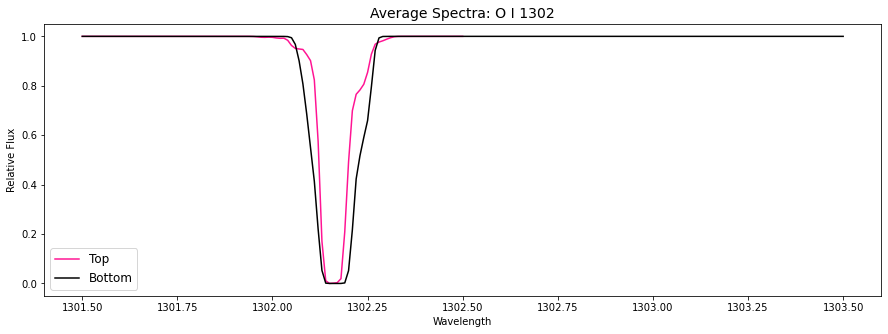

In [26]:
compare(oi1302_t[0], oi1302_t[1], oi1302_b[0], oi1302_b[1], ' O I 1302')

## Si II 1304

yt : [INFO     ] 2021-11-29 14:56:42,529 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:56:42,532 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:56:43,637 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:56:43,795 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:56:43,796 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:56:43,797 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:56:43,797 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 14:56:51,219 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:56:51,220 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:56:51,221 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:56:51,223 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:56:51,237 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:56:51,243 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:56:51,377 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:56:51,382 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1603.80it/s]
yt : [INFO     ] 2021-11-29 14:56:51,448 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:56:51,462 Getting segment at z = 0.0: [0.05645312 0.309      

yt : [INFO     ] 2021-11-29 14:56:58,672 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1555.51it/s]
yt : [INFO     ] 2021-11-29 14:56:58,738 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:56:58,752 Getting segment at z = 0.0: [0.05840625 0.309      0.24695313] unitary to [0.05840625 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:56:58,754 Getting subsegment: [0.05840625000000001 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:56:59,780 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:56:59,899 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:56:59,901 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:56:59,903 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-1

yt : [INFO     ] 2021-11-29 14:57:06,781 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:57:06,902 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:57:06,903 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:57:06,904 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:57:06,905 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:57:06,905 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:57:06,907 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:57:06,924 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:57:06,931 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:57:07,196 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:57:07,204 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 14:57:14,216 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:57:14,222 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:57:14,352 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:57:14,358 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 957.85it/s]
yt : [INFO     ] 2021-11-29 14:57:14,430 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:57:14,445 Getting segment at z = 0.0: [0.0623125  0.309      0.24890625] unitary to [0.0623125  0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 14:57:14,447 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 14:57:15,498 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:57:15,625 Parameters: current_t

yt : [INFO     ] 2021-11-29 14:57:21,606 Getting subsegment: [0.06426562499999999 unitary, 0.309 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 14:57:22,646 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:57:22,763 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:57:22,764 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:57:22,765 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:57:22,766 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:57:22,766 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:57:22,769 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:57:22,791 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:57:22,798 Identified 

yt : [INFO     ] 2021-11-29 14:57:29,709 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:57:29,710 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:57:29,712 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:57:29,728 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:57:29,734 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:57:29,870 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:57:29,876 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 964.81it/s]
yt : [INFO     ] 2021-11-29 14:57:29,945 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:57:29,959 Getting segment at z = 0.0: [0.06621875 0.309      0.25085937] unitary to [0.06621875 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 14:57:29,9

Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 884.36it/s]
yt : [INFO     ] 2021-11-29 14:57:37,127 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:57:37,141 Getting segment at z = 0.0: [0.06817188 0.309      0.25085937] unitary to [0.06817188 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 14:57:37,143 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 14:57:38,186 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:57:38,313 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:57:38,314 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:57:38,314 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:57:38,315 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] co

yt : [INFO     ] 2021-11-29 14:57:45,418 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:57:45,419 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:57:45,419 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:57:45,420 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:57:45,421 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:57:45,423 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:57:45,438 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:57:45,448 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:57:45,582 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:57:45,587 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1073

yt : [INFO     ] 2021-11-29 14:57:52,633 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:57:52,639 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:57:52,777 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:57:52,782 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1525.20it/s]
yt : [INFO     ] 2021-11-29 14:57:52,848 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:57:52,861 Getting segment at z = 0.0: [0.07207812 0.309      0.2528125 ] unitary to [0.07207812 0.34       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 14:57:52,863 Getting subsegment: [0.07207812499999999 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07207812499999999 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 14:57:53,896 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:57:54,020 Pa

yt : [INFO     ] 2021-11-29 14:58:00,832 Getting subsegment: [0.07403125 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 14:58:01,885 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:58:01,998 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:58:01,999 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:58:01,999 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:58:02,000 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:58:02,001 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:58:02,003 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:58:02,019 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:58:02,027 Identified 2.500e+01 octs
yt : 

yt : [INFO     ] 2021-11-29 14:58:09,979 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:58:09,981 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:58:09,994 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:58:10,002 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 14:58:10,142 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:58:10,149 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1295.74it/s]
yt : [INFO     ] 2021-11-29 14:58:10,217 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:58:10,232 Getting segment at z = 0.0: [0.0779375 0.309     0.245    ] unitary to [0.0779375 0.34      0.245    ] unitary.
yt : [INFO     ] 2021-11-29 14:58:10,234 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.245 unitary] to [0.07793749999999999 unitary, 0.34 unitary, 

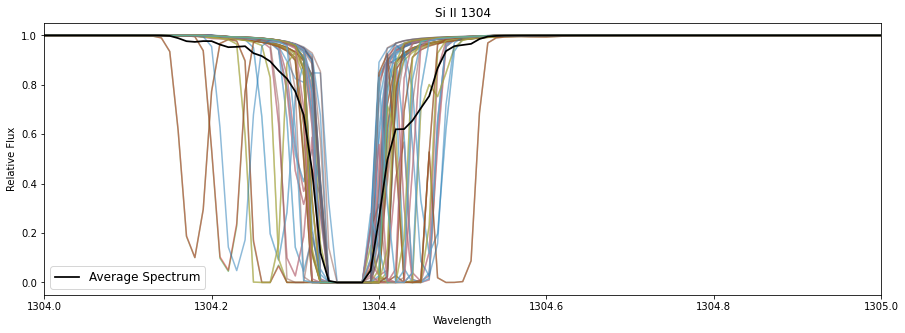

In [27]:
si1304_t = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
                   'Si II 1304', False, False, 1304, 1305,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 14:58:29,179 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 14:58:29,183 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 14:58:30,586 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:58:30,766 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:58:30,767 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:58:30,767 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:58:30,768 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 14:58:40,729 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:58:40,730 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:58:40,731 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:58:40,733 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:58:40,735 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:58:40,758 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:58:40,766 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:58:40,990 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:58:40,996 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 878.82it/s]
yt : [INFO     ] 2021-11-29 14:58:41,115 Writing spectrum to ascii file: spec.txt.
yt :

yt : [INFO     ] 2021-11-29 14:58:49,625 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:58:49,787 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:58:49,793 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1106.72it/s]
yt : [INFO     ] 2021-11-29 14:58:49,894 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:58:49,910 Getting segment at z = 0.0: [0.05840625 0.135      0.24695313] unitary to [0.05840625 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 14:58:49,913 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:58:51,212 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:58:51,343 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 

yt : [INFO     ] 2021-11-29 14:59:00,973 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 14:59:02,310 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:59:02,433 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:59:02,434 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:59:02,435 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:59:02,436 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:59:02,437 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:59:02,440 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:59:02,456 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:59:0

yt : [INFO     ] 2021-11-29 14:59:11,346 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:59:11,346 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:59:11,349 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:59:11,365 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:59:11,372 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:59:11,725 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:59:11,735 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 955.48it/s]
yt : [INFO     ] 2021-11-29 14:59:11,848 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:59:11,862 Getting segment at z = 0.0: [0.0623125  0.135      0.24890625] unitary to [0.0623125  0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 14:59:11,8

yt : [INFO     ] 2021-11-29 14:59:20,915 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 937.41it/s]
yt : [INFO     ] 2021-11-29 14:59:21,023 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:59:21,043 Getting segment at z = 0.0: [0.06426562 0.135      0.24890625] unitary to [0.06426562 0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 14:59:21,046 Getting subsegment: [0.06426562499999999 unitary, 0.135 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.22000000000000003 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 14:59:22,338 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:59:22,470 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:59:22,471 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:59:22,472 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29

yt : [INFO     ] 2021-11-29 14:59:31,392 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:59:31,530 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:59:31,531 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:59:31,532 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:59:31,533 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:59:31,534 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:59:31,537 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:59:31,553 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:59:31,559 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:59:31,736 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:59:31,743 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 14:59:40,453 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 14:59:40,472 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 14:59:40,478 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 14:59:40,660 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 14:59:40,667 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 948.32it/s]
yt : [INFO     ] 2021-11-29 14:59:40,774 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 14:59:40,790 Getting segment at z = 0.0: [0.06817188 0.135      0.25085937] unitary to [0.06817188 0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 14:59:40,792 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 14:59:42,101 Saving field

yt : [INFO     ] 2021-11-29 14:59:50,716 Getting segment at z = 0.0: [0.070125   0.135      0.25085937] unitary to [0.070125   0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 14:59:50,720 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.250859375 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 14:59:52,171 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 14:59:52,371 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 14:59:52,372 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 14:59:52,374 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 14:59:52,375 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 14:59:52,376 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 14:59:52,379 Setting i

yt : [INFO     ] 2021-11-29 15:00:02,564 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:00:02,565 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:00:02,566 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:00:02,567 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:00:02,569 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:00:02,586 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:00:02,594 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:00:02,796 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:00:02,804 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 762.02it/s]
yt : [INFO     ] 2021-11-29 15:00:02,948 Writing spectrum to ascii file: spec.txt.
yt :

yt : [INFO     ] 2021-11-29 15:00:12,934 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:00:13,094 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:00:13,101 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 994.41it/s]
yt : [INFO     ] 2021-11-29 15:00:13,206 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:00:13,221 Getting segment at z = 0.0: [0.07403125 0.135      0.2528125 ] unitary to [0.07403125 0.22       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:00:13,224 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:00:14,627 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:00:14,858 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:00:14,859 Parameters: dom

yt : [INFO     ] 2021-11-29 15:00:22,475 Getting subsegment: [0.07598437499999999 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07598437499999999 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:00:23,730 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:00:23,870 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:00:23,871 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:00:23,872 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:00:23,873 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:00:23,873 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:00:23,875 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:00:23,890 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:00:23,89

yt : [INFO     ] 2021-11-29 15:00:32,433 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:00:32,433 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:00:32,435 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:00:32,451 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:00:32,457 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:00:32,788 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:00:32,796 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1240.80it/s]
yt : [INFO     ] 2021-11-29 15:00:32,892 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:00:32,907 Getting segment at z = 0.0: [0.07989063 0.135      0.245     ] unitary to [0.07989063 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 15:00:32,

yt : [INFO     ] 2021-11-29 15:00:41,654 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 821.49it/s]
yt : [INFO     ] 2021-11-29 15:00:41,800 Writing spectrum to ascii file: spec.txt.


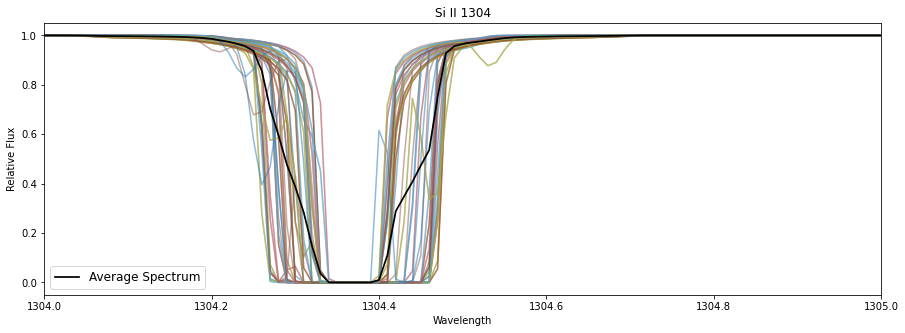

In [28]:
si1304_b = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
                   'Si II 1304', False, False, 1304, 1305,
                   False, False, False, False, DIY=False, ind_p=True)

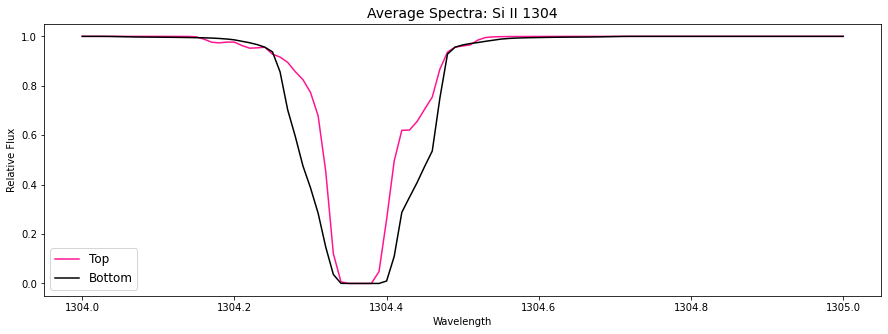

In [29]:
compare(si1304_t[0], si1304_t[1], si1304_b[0], si1304_b[1], ' Si II 1304')

## C II 1335

yt : [INFO     ] 2021-11-29 15:14:16,142 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:14:16,144 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:14:17,530 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:14:17,675 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:14:17,676 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:14:17,677 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:14:17,678 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 15:14:27,286 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:14:27,287 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:14:27,288 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:14:27,290 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:14:27,304 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:14:27,310 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:14:27,468 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:14:27,474 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1118.80it/s]
yt : [INFO     ] 2021-11-29 15:14:27,551 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:14:27,572 Getting segment at z = 0.0: [0.05645312 0.309      0.

yt : [INFO     ] 2021-11-29 15:14:37,171 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1654.83it/s]
yt : [INFO     ] 2021-11-29 15:14:37,240 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:14:37,256 Getting segment at z = 0.0: [0.05840625 0.309      0.24695313] unitary to [0.05840625 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:14:37,258 Getting subsegment: [0.05840625000000001 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:14:38,500 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:14:38,635 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:14:38,636 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:14:38,636 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11

yt : [INFO     ] 2021-11-29 15:14:46,916 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:14:47,068 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:14:47,069 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:14:47,070 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:14:47,070 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:14:47,071 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:14:47,074 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:14:47,095 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:14:47,102 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:14:47,263 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:14:47,268 Creating spectrum
Addi

yt : [INFO     ] 2021-11-29 15:14:55,878 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:14:56,038 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:14:56,044 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1060.05it/s]
yt : [INFO     ] 2021-11-29 15:14:56,123 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:14:56,138 Getting segment at z = 0.0: [0.0623125  0.309      0.24890625] unitary to [0.0623125  0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:14:56,140 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:14:57,383 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:14:57,523 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:14:57,524 Parameters: domain_dimensions  

yt : [INFO     ] 2021-11-29 15:15:05,786 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:15:05,922 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:15:05,923 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:15:05,924 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:15:05,925 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:15:05,926 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:15:05,930 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:15:05,949 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:15:05,955 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:15:06,115 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:15:06,121 Creating spectrum
Addi

yt : [INFO     ] 2021-11-29 15:15:15,270 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:15:15,284 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:15:15,290 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:15:15,461 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:15:15,467 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1028.67it/s]
yt : [INFO     ] 2021-11-29 15:15:15,546 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:15:15,562 Getting segment at z = 0.0: [0.06621875 0.309      0.25085937] unitary to [0.06621875 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:15:15,565 Getting subsegment: [0.06621874999999999 unitary, 0.309 unitary, 0.250859375 unitary] to [0.06621874999999999 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:15:16,848 Saving field

yt : [INFO     ] 2021-11-29 15:15:25,321 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:15:26,722 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:15:26,877 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:15:26,878 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:15:26,879 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:15:26,880 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:15:26,882 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:15:26,885 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:15:26,907 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:15:26,916 Identified 2.500e+01 octs

yt : [INFO     ] 2021-11-29 15:15:36,617 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:15:36,621 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:15:36,647 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:15:36,659 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:15:36,900 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:15:36,906 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 908.31it/s]
yt : [INFO     ] 2021-11-29 15:15:36,986 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:15:37,008 Getting segment at z = 0.0: [0.070125  0.309     0.2528125] unitary to [0.070125  0.34      0.2528125] unitary.
yt : [INFO     ] 2021-11-29 15:15:37,011 Getting subsegment: [0.07012499999999999 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07012499999999999 unitary, 0.34 unitary,

yt : [INFO     ] 2021-11-29 15:15:56,935 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:15:56,936 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:15:56,938 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:15:56,939 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:15:56,942 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:15:56,967 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:15:56,977 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:15:57,210 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:15:57,216 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1581.70it/s]
yt : [INFO     ] 2021-11-29 15:15:57,299 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-11-29 15:16:05,921 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:16:06,092 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:16:06,097 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1701.38it/s]
yt : [INFO     ] 2021-11-29 15:16:06,171 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:16:06,188 Getting segment at z = 0.0: [0.0779375 0.309     0.245    ] unitary to [0.0779375 0.34      0.245    ] unitary.
yt : [INFO     ] 2021-11-29 15:16:06,190 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.245 unitary] to [0.07793749999999999 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:16:07,455 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:16:07,596 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:16:07,597 Parameters: domain_dimensio

yt : [INFO     ] 2021-11-29 15:16:15,422 Getting subsegment: [0.079890625 unitary, 0.309 unitary, 0.245 unitary] to [0.079890625 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:16:16,743 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:16:16,957 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:16:16,958 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:16:16,959 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:16:16,960 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:16:16,961 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:16:16,965 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:16:16,990 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:16:17,001 Identified 2.500e+01 octs
yt : [INFO 

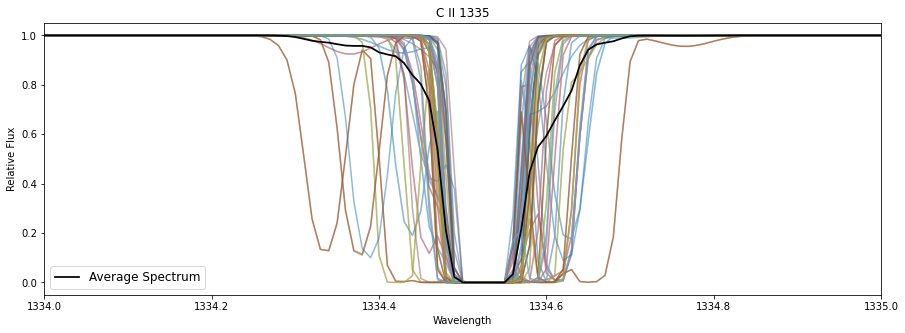

In [38]:
cii1335_t = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
                   'C II 1335', False, False, 1334, 1335,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 15:16:24,919 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:16:24,921 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:16:26,299 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:16:26,492 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:16:26,493 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:16:26,494 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:16:26,496 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 15:16:35,838 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:16:35,839 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:16:35,840 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:16:35,841 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:16:35,844 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:16:35,864 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:16:35,872 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:16:36,035 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:16:36,040 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1547.92it/s]
yt : [INFO     ] 2021-11-29 15:16:36,129 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-11-29 15:16:45,544 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:16:45,761 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:16:45,769 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 989.63it/s]
yt : [INFO     ] 2021-11-29 15:16:45,890 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:16:45,907 Getting segment at z = 0.0: [0.05840625 0.135      0.24695313] unitary to [0.05840625 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:16:45,909 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:16:47,267 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:16:47,426 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 202

yt : [INFO     ] 2021-11-29 15:16:55,190 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:16:56,482 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:16:56,655 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:16:56,656 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:16:56,656 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:16:56,657 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:16:56,658 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:16:56,660 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:16:56,676 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:16:5

yt : [INFO     ] 2021-11-29 15:17:05,298 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:17:05,299 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:17:05,301 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:17:05,317 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:17:05,323 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:17:05,483 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:17:05,489 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1362.65it/s]
yt : [INFO     ] 2021-11-29 15:17:05,583 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:17:05,599 Getting segment at z = 0.0: [0.0623125  0.135      0.24890625] unitary to [0.0623125  0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:17:05,60

yt : [INFO     ] 2021-11-29 15:17:14,371 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1393.19it/s]
yt : [INFO     ] 2021-11-29 15:17:14,466 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:17:14,483 Getting segment at z = 0.0: [0.06426562 0.135      0.24890625] unitary to [0.06426562 0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:17:14,485 Getting subsegment: [0.06426562499999999 unitary, 0.135 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.22000000000000003 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:17:15,743 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:17:15,884 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:17:15,885 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:17:15,886 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29

yt : [INFO     ] 2021-11-29 15:17:24,520 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:17:24,656 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:17:24,656 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:17:24,657 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:17:24,658 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:17:24,659 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:17:24,661 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:17:24,677 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:17:24,683 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:17:24,844 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:17:24,849 Creating spectrum
Addi

yt : [INFO     ] 2021-11-29 15:17:33,632 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:17:33,646 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:17:33,653 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:17:33,813 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:17:33,821 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1356.48it/s]
yt : [INFO     ] 2021-11-29 15:17:33,913 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:17:33,931 Getting segment at z = 0.0: [0.06817188 0.135      0.25085937] unitary to [0.06817188 0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:17:33,933 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:17:35,167 Saving field 

yt : [INFO     ] 2021-11-29 15:17:42,679 Getting segment at z = 0.0: [0.070125   0.135      0.25085937] unitary to [0.070125   0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:17:42,681 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.250859375 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:17:43,974 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:17:44,167 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:17:44,168 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:17:44,169 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:17:44,170 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:17:44,171 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:17:44,174 Setting i

yt : [INFO     ] 2021-11-29 15:17:53,126 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:17:53,126 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:17:53,128 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:17:53,129 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:17:53,131 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:17:53,154 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:17:53,162 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:17:53,415 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:17:53,421 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1481.76it/s]
yt : [INFO     ] 2021-11-29 15:17:53,524 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-11-29 15:18:01,974 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:18:02,130 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:18:02,136 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1403.46it/s]
yt : [INFO     ] 2021-11-29 15:18:02,237 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:18:02,254 Getting segment at z = 0.0: [0.07403125 0.135      0.2528125 ] unitary to [0.07403125 0.22       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:18:02,256 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:18:03,600 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:18:03,774 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:18:03,775 Parameters: doma

yt : [INFO     ] 2021-11-29 15:18:11,194 Getting subsegment: [0.07598437499999999 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07598437499999999 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:18:12,446 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:18:12,615 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:18:12,616 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:18:12,617 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:18:12,618 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:18:12,619 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:18:12,621 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:18:12,638 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:18:12,64

yt : [INFO     ] 2021-11-29 15:18:22,119 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:18:22,120 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:18:22,124 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:18:22,145 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:18:22,155 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:18:22,380 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:18:22,386 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1173.40it/s]
yt : [INFO     ] 2021-11-29 15:18:22,500 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:18:22,520 Getting segment at z = 0.0: [0.07989063 0.135      0.245     ] unitary to [0.07989063 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 15:18:22,52

yt : [INFO     ] 2021-11-29 15:18:31,712 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1354.19it/s]
yt : [INFO     ] 2021-11-29 15:18:31,810 Writing spectrum to ascii file: spec.txt.


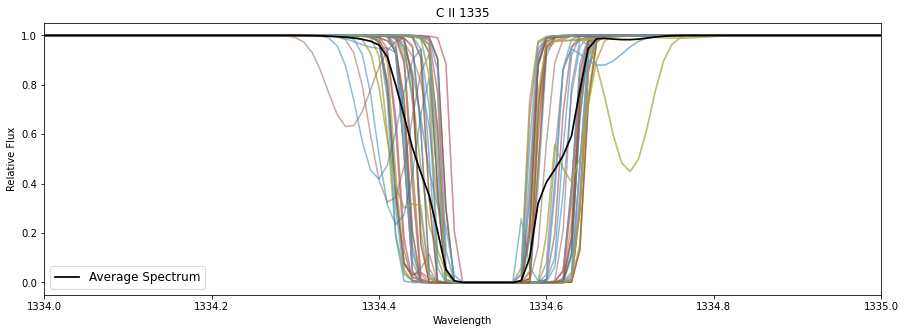

In [39]:
cii1335_b = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
                   'C II 1335', False, False, 1334, 1335,
                   False, False, False, False, DIY=False, ind_p=True)

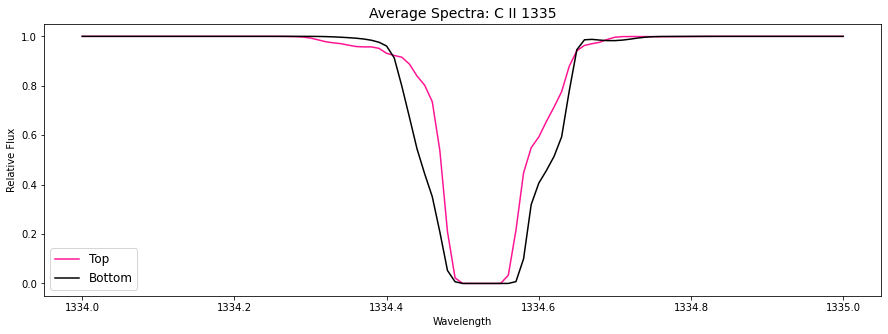

In [40]:
compare(cii1335_t[0], cii1335_t[1], cii1335_b[0], cii1335_b[1], ' C II 1335')

## Si IV 1393

yt : [INFO     ] 2021-11-29 15:10:12,213 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:10:12,215 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:10:13,482 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:10:13,660 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:10:13,661 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:10:13,662 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:10:13,663 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 15:10:22,861 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:10:22,862 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:10:22,863 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:10:22,866 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:10:22,881 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:10:22,889 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:10:23,271 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:10:23,279 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2036.36it/s]
yt : [INFO     ] 2021-11-29 15:10:23,355 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:10:23,369 Getting segment at z = 0.0: [0.05645312 0.309      

yt : [INFO     ] 2021-11-29 15:10:31,822 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1727.26it/s]
yt : [INFO     ] 2021-11-29 15:10:31,900 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:10:31,920 Getting segment at z = 0.0: [0.05840625 0.309      0.24695313] unitary to [0.05840625 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:10:31,922 Getting subsegment: [0.05840625000000001 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:10:33,199 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:10:33,335 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:10:33,337 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:10:33,338 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-1

yt : [INFO     ] 2021-11-29 15:10:41,785 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:10:41,918 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:10:41,919 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:10:41,919 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:10:41,921 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:10:41,922 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:10:41,925 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:10:41,952 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:10:41,960 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:10:42,128 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:10:42,133 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:10:50,271 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:10:50,281 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:10:50,459 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:10:50,465 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1167.83it/s]
yt : [INFO     ] 2021-11-29 15:10:50,543 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:10:50,562 Getting segment at z = 0.0: [0.0623125  0.309      0.24890625] unitary to [0.0623125  0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:10:50,565 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:10:51,898 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:10:52,056 Parameters: current_

yt : [INFO     ] 2021-11-29 15:10:59,547 Getting subsegment: [0.06426562499999999 unitary, 0.309 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:11:00,834 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:11:00,964 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:11:00,965 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:11:00,966 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:11:00,967 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:11:00,968 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:11:00,970 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:11:00,987 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:11:00,995 Identified 

yt : [INFO     ] 2021-11-29 15:11:09,407 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:11:09,408 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:11:09,410 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:11:09,426 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:11:09,435 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:11:09,603 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:11:09,609 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1264.87it/s]
yt : [INFO     ] 2021-11-29 15:11:09,686 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:11:09,703 Getting segment at z = 0.0: [0.06621875 0.309      0.25085937] unitary to [0.06621875 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:11:09,

Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1988.99it/s]
yt : [INFO     ] 2021-11-29 15:11:18,177 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:11:18,194 Getting segment at z = 0.0: [0.06817188 0.309      0.25085937] unitary to [0.06817188 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:11:18,196 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:11:19,429 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:11:19,561 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:11:19,562 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:11:19,562 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:11:19,563 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-11-29 15:11:28,177 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:11:28,177 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:11:28,178 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:11:28,178 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:11:28,179 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:11:28,181 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:11:28,197 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:11:28,206 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:11:28,380 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:11:28,386 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1401

yt : [INFO     ] 2021-11-29 15:11:38,146 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:11:38,153 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:11:38,334 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:11:38,342 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1776.58it/s]
yt : [INFO     ] 2021-11-29 15:11:38,414 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:11:38,428 Getting segment at z = 0.0: [0.07207812 0.309      0.2528125 ] unitary to [0.07207812 0.34       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:11:38,429 Getting subsegment: [0.07207812499999999 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07207812499999999 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:11:39,810 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:11:40,013 Pa

yt : [INFO     ] 2021-11-29 15:11:47,262 Getting subsegment: [0.07403125 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:11:48,528 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:11:48,663 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:11:48,664 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:11:48,666 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:11:48,667 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:11:48,668 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:11:48,670 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:11:48,687 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:11:48,696 Identified 2.500e+01 octs
yt : 

yt : [INFO     ] 2021-11-29 15:11:57,375 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:11:57,377 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:11:57,395 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:11:57,402 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:11:57,563 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:11:57,569 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1860.78it/s]
yt : [INFO     ] 2021-11-29 15:11:57,642 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:11:57,661 Getting segment at z = 0.0: [0.0779375 0.309     0.245    ] unitary to [0.0779375 0.34      0.245    ] unitary.
yt : [INFO     ] 2021-11-29 15:11:57,663 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.245 unitary] to [0.07793749999999999 unitary, 0.34 unitary, 

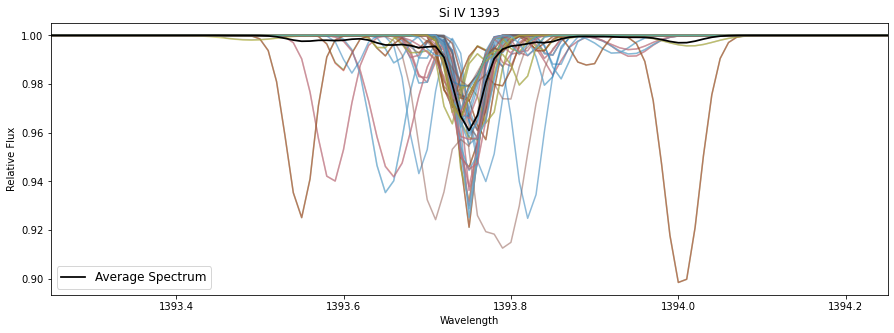

In [35]:
si1393_t = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
                    'Si IV 1393', 'Si', 'IV', 1393.25, 1394.25, 1393.76, 9.0E+8, 5.24E-01, 28.08,
                    DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-29 15:12:15,171 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:12:15,175 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:12:16,497 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:12:16,629 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:12:16,629 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:12:16,630 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:12:16,632 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 15:12:25,311 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:12:25,311 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:12:25,312 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:12:25,313 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:12:25,316 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:12:25,332 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:12:25,339 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:12:25,500 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:12:25,505 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1835.09it/s]
yt : [INFO     ] 2021-11-29 15:12:25,595 Writing spectrum to ascii file: spec.txt.
yt 

yt : [INFO     ] 2021-11-29 15:12:34,217 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:12:34,399 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:12:34,406 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1919.97it/s]
yt : [INFO     ] 2021-11-29 15:12:34,504 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:12:34,523 Getting segment at z = 0.0: [0.05840625 0.135      0.24695313] unitary to [0.05840625 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:12:34,526 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:12:35,800 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:12:35,943 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 

yt : [INFO     ] 2021-11-29 15:12:43,103 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:12:44,414 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:12:44,554 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:12:44,555 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:12:44,556 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:12:44,557 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:12:44,558 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:12:44,561 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:12:44,579 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:12:4

yt : [INFO     ] 2021-11-29 15:12:53,436 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:12:53,437 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:12:53,439 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:12:53,456 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:12:53,464 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:12:53,624 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:12:53,630 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1851.46it/s]
yt : [INFO     ] 2021-11-29 15:12:53,719 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:12:53,735 Getting segment at z = 0.0: [0.0623125  0.135      0.24890625] unitary to [0.0623125  0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:12:53,

yt : [INFO     ] 2021-11-29 15:13:02,434 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1846.58it/s]
yt : [INFO     ] 2021-11-29 15:13:02,519 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:13:02,534 Getting segment at z = 0.0: [0.06426562 0.135      0.24890625] unitary to [0.06426562 0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:13:02,536 Getting subsegment: [0.06426562499999999 unitary, 0.135 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.22000000000000003 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:13:03,854 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:13:04,008 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:13:04,009 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:13:04,010 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-2

yt : [INFO     ] 2021-11-29 15:13:12,254 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:13:12,390 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:13:12,391 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:13:12,392 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:13:12,394 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:13:12,394 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:13:12,398 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:13:12,415 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:13:12,422 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:13:12,577 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:13:12,583 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:13:20,957 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:13:20,971 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:13:20,979 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:13:21,141 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:13:21,147 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2200.58it/s]
yt : [INFO     ] 2021-11-29 15:13:21,233 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:13:21,250 Getting segment at z = 0.0: [0.06817188 0.135      0.25085937] unitary to [0.06817188 0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:13:21,252 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:13:22,480 Saving fiel

yt : [INFO     ] 2021-11-29 15:13:29,560 Getting segment at z = 0.0: [0.070125   0.135      0.25085937] unitary to [0.070125   0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:13:29,562 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.250859375 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:13:30,815 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:13:30,945 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:13:30,946 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:13:30,947 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:13:30,948 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:13:30,949 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:13:30,952 Setting i

yt : [INFO     ] 2021-11-29 15:13:39,669 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:13:39,669 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:13:39,671 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:13:39,672 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:13:39,675 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:13:39,690 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:13:39,698 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:13:39,853 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:13:39,858 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2031.39it/s]
yt : [INFO     ] 2021-11-29 15:13:39,941 Writing spectrum to ascii file: spec.txt.
yt 

yt : [INFO     ] 2021-11-29 15:13:48,026 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:13:48,183 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:13:48,189 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1912.63it/s]
yt : [INFO     ] 2021-11-29 15:13:48,273 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:13:48,289 Getting segment at z = 0.0: [0.07403125 0.135      0.2528125 ] unitary to [0.07403125 0.22       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:13:48,291 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:13:49,531 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:13:49,672 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:13:49,673 Parameters: do

yt : [INFO     ] 2021-11-29 15:13:56,866 Getting subsegment: [0.07598437499999999 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07598437499999999 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:13:58,103 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:13:58,236 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:13:58,237 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:13:58,238 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:13:58,239 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:13:58,240 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:13:58,243 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:13:58,261 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:13:58,27

yt : [INFO     ] 2021-11-29 15:14:06,528 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:14:06,529 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:14:06,532 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:14:06,547 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:14:06,556 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:14:06,710 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:14:06,716 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2373.63it/s]
yt : [INFO     ] 2021-11-29 15:14:06,793 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:14:06,808 Getting segment at z = 0.0: [0.07989063 0.135      0.245     ] unitary to [0.07989063 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 15:14:06,

yt : [INFO     ] 2021-11-29 15:14:15,358 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1800.10it/s]
yt : [INFO     ] 2021-11-29 15:14:15,469 Writing spectrum to ascii file: spec.txt.


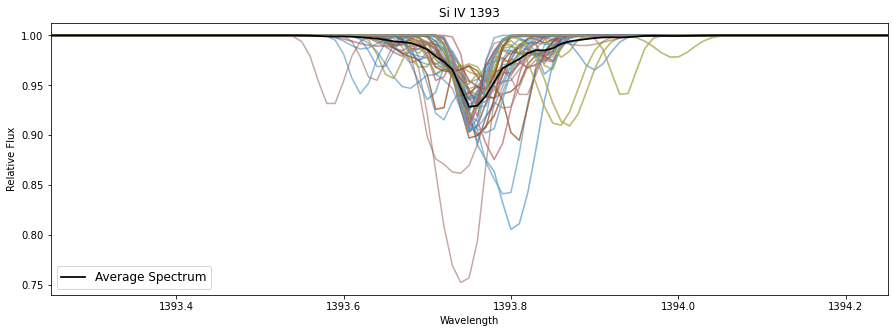

In [36]:
si1393_b = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
                    'Si IV 1393', 'Si', 'IV', 1393.25, 1394.25, 1393.76, 9.0E+8, 5.24E-01, 28.08,
                    DIY=True, ind_p=True)

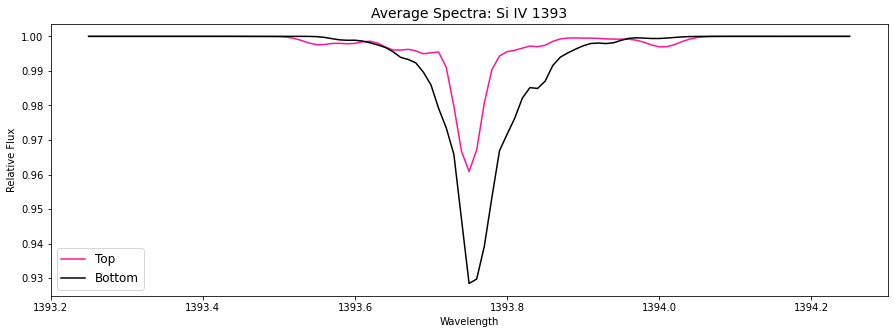

In [37]:
compare(si1393_t[0], si1393_t[1], si1393_b[0], si1393_b[1], ' Si IV 1393')

## Al III 1854

yt : [INFO     ] 2021-11-29 15:18:32,387 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:18:32,393 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:18:33,809 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:18:33,961 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:18:33,962 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:18:33,963 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:18:33,964 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 15:18:43,314 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:18:43,315 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:18:43,317 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:18:43,320 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:18:43,342 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:18:43,350 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:18:43,540 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:18:43,546 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2139.18it/s]
yt : [INFO     ] 2021-11-29 15:18:43,612 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:18:43,626 Getting segment at z = 0.0: [0.05645312 0.309     

yt : [INFO     ] 2021-11-29 15:18:52,900 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2032.53it/s]
yt : [INFO     ] 2021-11-29 15:18:52,970 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:18:52,988 Getting segment at z = 0.0: [0.05840625 0.309      0.24695313] unitary to [0.05840625 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:18:52,992 Getting subsegment: [0.05840625000000001 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:18:54,265 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:18:54,401 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:18:54,402 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:18:54,403 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-

yt : [INFO     ] 2021-11-29 15:19:02,877 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:19:03,040 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:19:03,041 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:19:03,043 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:19:03,044 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:19:03,046 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:19:03,049 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:19:03,074 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:19:03,085 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:19:03,327 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:19:03,335 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:19:12,158 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:19:12,164 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:19:12,323 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:19:12,329 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1732.59it/s]
yt : [INFO     ] 2021-11-29 15:19:12,400 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:19:12,415 Getting segment at z = 0.0: [0.0623125  0.309      0.24890625] unitary to [0.0623125  0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:19:12,417 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:19:13,667 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:19:13,801 Parameters: current

yt : [INFO     ] 2021-11-29 15:19:20,954 Getting subsegment: [0.06426562499999999 unitary, 0.309 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:19:22,226 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:19:22,358 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:19:22,359 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:19:22,360 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:19:22,361 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:19:22,362 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:19:22,364 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:19:22,382 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:19:22,388 Identified 

yt : [INFO     ] 2021-11-29 15:19:31,281 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:19:31,282 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:19:31,284 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:19:31,299 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:19:31,305 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:19:31,486 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:19:31,492 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1192.74it/s]
yt : [INFO     ] 2021-11-29 15:19:31,576 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:19:31,593 Getting segment at z = 0.0: [0.06621875 0.309      0.25085937] unitary to [0.06621875 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:19:31

Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1345.88it/s]
yt : [INFO     ] 2021-11-29 15:19:40,375 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:19:40,391 Getting segment at z = 0.0: [0.06817188 0.309      0.25085937] unitary to [0.06817188 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:19:40,393 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:19:41,650 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:19:41,795 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:19:41,796 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:19:41,797 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:19:41,798 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] 

yt : [INFO     ] 2021-11-29 15:19:50,444 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:19:50,445 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:19:50,446 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:19:50,447 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:19:50,448 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:19:50,451 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:19:50,466 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:19:50,475 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:19:50,630 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:19:50,636 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 145

yt : [INFO     ] 2021-11-29 15:19:59,869 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:19:59,878 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:20:00,091 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:20:00,097 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2019.00it/s]
yt : [INFO     ] 2021-11-29 15:20:00,169 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:20:00,184 Getting segment at z = 0.0: [0.07207812 0.309      0.2528125 ] unitary to [0.07207812 0.34       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:20:00,186 Getting subsegment: [0.07207812499999999 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07207812499999999 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:20:01,646 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:20:01,897 P

yt : [INFO     ] 2021-11-29 15:20:09,855 Getting subsegment: [0.07403125 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:20:11,225 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:20:11,408 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:20:11,409 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:20:11,410 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:20:11,412 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:20:11,413 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:20:11,415 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:20:11,431 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:20:11,441 Identified 2.500e+01 octs
yt : 

yt : [INFO     ] 2021-11-29 15:20:20,254 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:20:20,256 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:20:20,271 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:20:20,276 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:20:20,437 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:20:20,443 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2199.15it/s]
yt : [INFO     ] 2021-11-29 15:20:20,513 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:20:20,527 Getting segment at z = 0.0: [0.0779375 0.309     0.245    ] unitary to [0.0779375 0.34      0.245    ] unitary.
yt : [INFO     ] 2021-11-29 15:20:20,529 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.245 unitary] to [0.07793749999999999 unitary, 0.34 unitary,

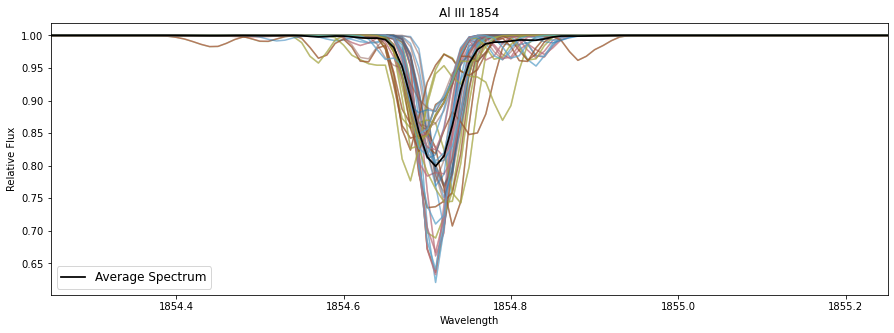

In [41]:
al1854_t = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
                    'Al III 1854', 'Al', 'III', 1854.25, 1855.25, 1854.72, 5.57E+08, 5.75E-01, 26.98,
                    DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-29 15:20:38,862 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:20:38,865 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:20:40,216 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:20:40,372 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:20:40,372 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:20:40,373 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:20:40,374 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 15:20:50,464 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:20:50,465 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:20:50,466 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:20:50,468 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:20:50,470 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:20:50,489 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:20:50,498 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:20:50,662 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:20:50,671 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2228.40it/s]
yt : [INFO     ] 2021-11-29 15:20:50,751 Writing spectrum to ascii file: spec.txt.
yt

yt : [INFO     ] 2021-11-29 15:20:59,276 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:20:59,446 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:20:59,452 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1807.38it/s]
yt : [INFO     ] 2021-11-29 15:20:59,542 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:20:59,557 Getting segment at z = 0.0: [0.05840625 0.135      0.24695313] unitary to [0.05840625 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:20:59,559 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:21:00,849 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:21:00,991 Parameters: current_time              = 0.0 code_time
yt : [INFO     ]

yt : [INFO     ] 2021-11-29 15:21:08,162 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:21:09,415 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:21:09,554 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:21:09,555 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:21:09,556 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:21:09,557 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:21:09,557 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:21:09,559 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:21:09,575 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:21:0

yt : [INFO     ] 2021-11-29 15:21:18,269 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:21:18,270 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:21:18,272 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:21:18,287 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:21:18,293 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:21:18,454 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:21:18,460 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1872.02it/s]
yt : [INFO     ] 2021-11-29 15:21:18,548 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:21:18,564 Getting segment at z = 0.0: [0.0623125  0.135      0.24890625] unitary to [0.0623125  0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:21:18

yt : [INFO     ] 2021-11-29 15:21:26,967 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1712.53it/s]
yt : [INFO     ] 2021-11-29 15:21:27,054 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:21:27,072 Getting segment at z = 0.0: [0.06426562 0.135      0.24890625] unitary to [0.06426562 0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:21:27,074 Getting subsegment: [0.06426562499999999 unitary, 0.135 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.22000000000000003 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:21:28,371 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:21:28,508 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:21:28,509 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:21:28,509 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-

yt : [INFO     ] 2021-11-29 15:21:37,655 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:21:37,793 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:21:37,794 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:21:37,795 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:21:37,796 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:21:37,796 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:21:37,799 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:21:37,815 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:21:37,823 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:21:37,981 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:21:37,987 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:21:46,717 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:21:46,734 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:21:46,740 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:21:46,910 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:21:46,916 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1286.26it/s]
yt : [INFO     ] 2021-11-29 15:21:47,012 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:21:47,029 Getting segment at z = 0.0: [0.06817188 0.135      0.25085937] unitary to [0.06817188 0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:21:47,031 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:21:48,359 Saving fie

yt : [INFO     ] 2021-11-29 15:21:55,971 Getting segment at z = 0.0: [0.070125   0.135      0.25085937] unitary to [0.070125   0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:21:55,974 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.250859375 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:21:57,230 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:21:57,378 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:21:57,379 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:21:57,379 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:21:57,380 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:21:57,381 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:21:57,384 Setting i

yt : [INFO     ] 2021-11-29 15:22:06,036 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:22:06,037 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:22:06,038 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:22:06,038 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:22:06,041 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:22:06,058 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:22:06,065 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:22:06,216 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:22:06,222 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2009.86it/s]
yt : [INFO     ] 2021-11-29 15:22:06,303 Writing spectrum to ascii file: spec.txt.
yt

yt : [INFO     ] 2021-11-29 15:22:14,579 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:22:14,761 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:22:14,767 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1725.86it/s]
yt : [INFO     ] 2021-11-29 15:22:14,859 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:22:14,881 Getting segment at z = 0.0: [0.07403125 0.135      0.2528125 ] unitary to [0.07403125 0.22       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:22:14,885 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:22:16,142 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:22:16,290 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:22:16,291 Parameters: d

yt : [INFO     ] 2021-11-29 15:22:23,442 Getting subsegment: [0.07598437499999999 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07598437499999999 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:22:24,663 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:22:24,795 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:22:24,796 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:22:24,797 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:22:24,798 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:22:24,799 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:22:24,801 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:22:24,817 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:22:24,82

yt : [INFO     ] 2021-11-29 15:22:33,559 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:22:33,560 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:22:33,564 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:22:33,580 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:22:33,588 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:22:33,753 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:22:33,759 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2299.08it/s]
yt : [INFO     ] 2021-11-29 15:22:33,842 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:22:33,859 Getting segment at z = 0.0: [0.07989063 0.135      0.245     ] unitary to [0.07989063 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 15:22:33

yt : [INFO     ] 2021-11-29 15:22:42,503 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1234.47it/s]
yt : [INFO     ] 2021-11-29 15:22:42,615 Writing spectrum to ascii file: spec.txt.


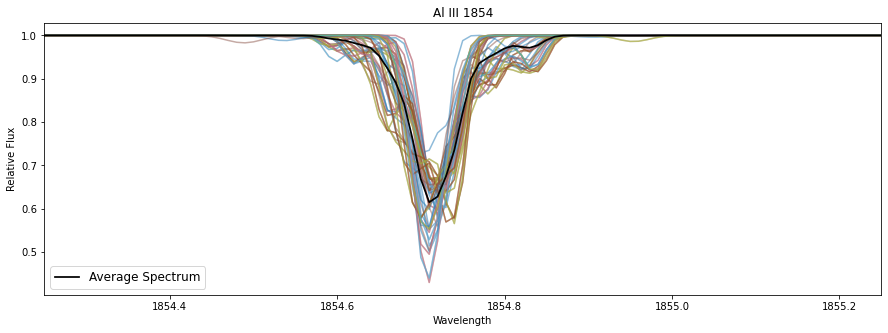

In [42]:
al1854_b = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
                    'Al III 1854', 'Al', 'III', 1854.25, 1855.25, 1854.72, 5.57E+08, 5.75E-01, 26.98,
                    DIY=True, ind_p=True)

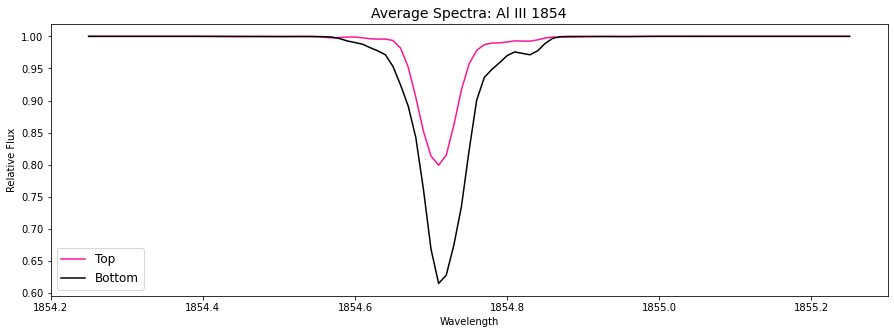

In [43]:
compare(al1854_t[0], al1854_t[1], al1854_b[0], al1854_b[1], ' Al III 1854')

## Fe II 2600

yt : [INFO     ] 2021-11-29 15:22:43,121 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:22:43,127 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:22:44,382 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:22:44,546 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:22:44,547 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:22:44,547 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:22:44,549 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 15:22:53,426 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:22:53,427 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:22:53,428 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:22:53,430 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:22:53,446 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:22:53,453 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:22:53,607 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:22:53,613 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1620.45it/s]
yt : [INFO     ] 2021-11-29 15:22:53,679 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:22:53,694 Getting segment at z = 0.0: [0.05645312 0.309      

yt : [INFO     ] 2021-11-29 15:23:01,790 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1727.10it/s]
yt : [INFO     ] 2021-11-29 15:23:01,860 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:23:01,875 Getting segment at z = 0.0: [0.05840625 0.309      0.24695313] unitary to [0.05840625 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:23:01,877 Getting subsegment: [0.05840625000000001 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:23:03,127 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:23:03,264 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:23:03,265 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:23:03,266 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-1

yt : [INFO     ] 2021-11-29 15:23:12,909 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:23:13,107 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:23:13,108 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:23:13,109 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:23:13,110 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:23:13,111 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:23:13,114 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:23:13,142 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:23:13,151 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:23:13,399 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:23:13,407 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:23:23,056 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:23:23,063 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:23:23,268 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:23:23,275 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 747.55it/s]
yt : [INFO     ] 2021-11-29 15:23:23,385 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:23:23,408 Getting segment at z = 0.0: [0.0623125  0.309      0.24890625] unitary to [0.0623125  0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:23:23,410 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:23:24,778 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:23:24,965 Parameters: current_t

yt : [INFO     ] 2021-11-29 15:23:33,675 Getting subsegment: [0.06426562499999999 unitary, 0.309 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:23:35,060 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:23:35,215 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:23:35,216 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:23:35,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:23:35,218 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:23:35,219 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:23:35,222 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:23:35,243 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:23:35,253 Identified 

yt : [INFO     ] 2021-11-29 15:23:44,038 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:23:44,039 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:23:44,041 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:23:44,066 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:23:44,072 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:23:44,242 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:23:44,248 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1009.32it/s]
yt : [INFO     ] 2021-11-29 15:23:44,327 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:23:44,342 Getting segment at z = 0.0: [0.06621875 0.309      0.25085937] unitary to [0.06621875 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:23:44,

Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 986.08it/s]
yt : [INFO     ] 2021-11-29 15:23:53,249 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:23:53,265 Getting segment at z = 0.0: [0.06817188 0.309      0.25085937] unitary to [0.06817188 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:23:53,268 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:23:54,564 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:23:54,779 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:23:54,780 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:23:54,781 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:23:54,783 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] co

yt : [INFO     ] 2021-11-29 15:24:03,958 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:24:03,959 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:24:03,960 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:24:03,962 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:24:03,963 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:24:03,966 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:24:03,986 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:24:03,995 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:24:04,258 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:24:04,264 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 542.

yt : [INFO     ] 2021-11-29 15:24:13,013 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:24:13,019 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:24:13,183 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:24:13,189 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1424.64it/s]
yt : [INFO     ] 2021-11-29 15:24:13,263 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:24:13,278 Getting segment at z = 0.0: [0.07207812 0.309      0.2528125 ] unitary to [0.07207812 0.34       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:24:13,280 Getting subsegment: [0.07207812499999999 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07207812499999999 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:24:14,536 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:24:14,682 Pa

yt : [INFO     ] 2021-11-29 15:24:22,284 Getting subsegment: [0.07403125 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:24:23,523 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:24:23,665 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:24:23,666 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:24:23,667 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:24:23,668 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:24:23,669 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:24:23,671 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:24:23,687 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:24:23,694 Identified 2.500e+01 octs
yt : 

yt : [INFO     ] 2021-11-29 15:24:32,124 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:24:32,127 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:24:32,142 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:24:32,148 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:24:32,303 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:24:32,310 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1635.69it/s]
yt : [INFO     ] 2021-11-29 15:24:32,382 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:24:32,399 Getting segment at z = 0.0: [0.0779375 0.309     0.245    ] unitary to [0.0779375 0.34      0.245    ] unitary.
yt : [INFO     ] 2021-11-29 15:24:32,401 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.245 unitary] to [0.07793749999999999 unitary, 0.34 unitary, 

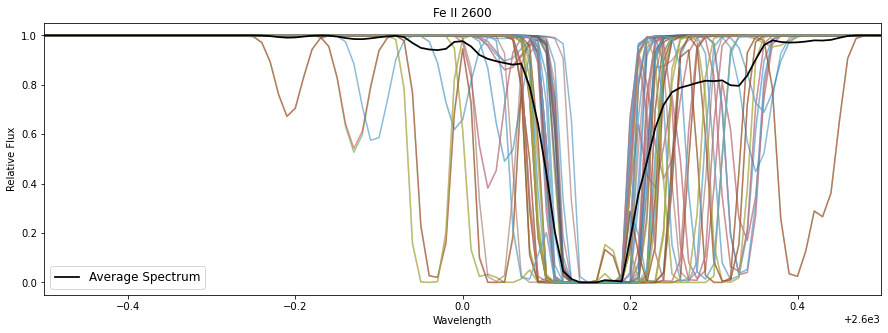

In [44]:
fe26_t = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
                  'Fe II 2600', 'Fe', 'II', 2599.5, 2600.50, 2600.17, 2.37E+08, 2.4E-01, 55.85,
                  DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-29 15:24:51,894 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:24:51,898 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:24:53,222 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:24:53,379 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:24:53,380 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:24:53,381 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:24:53,382 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 15:25:02,685 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:25:02,687 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:25:02,690 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:25:02,691 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:25:02,695 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:25:02,716 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:25:02,725 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:25:02,970 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:25:02,978 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1169.78it/s]
yt : [INFO     ] 2021-11-29 15:25:03,096 Writing spectrum to ascii file: spec.txt.
yt 

yt : [INFO     ] 2021-11-29 15:25:12,501 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:25:12,669 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:25:12,675 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1563.10it/s]
yt : [INFO     ] 2021-11-29 15:25:12,763 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:25:12,778 Getting segment at z = 0.0: [0.05840625 0.135      0.24695313] unitary to [0.05840625 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:25:12,780 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:25:14,045 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:25:14,201 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 

yt : [INFO     ] 2021-11-29 15:25:21,271 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:25:22,749 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:25:22,887 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:25:22,888 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:25:22,889 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:25:22,890 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:25:22,891 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:25:22,894 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:25:22,911 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:25:2

yt : [INFO     ] 2021-11-29 15:25:31,377 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:25:31,378 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:25:31,380 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:25:31,398 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:25:31,404 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:25:31,565 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:25:31,571 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1421.33it/s]
yt : [INFO     ] 2021-11-29 15:25:31,663 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:25:31,678 Getting segment at z = 0.0: [0.0623125  0.135      0.24890625] unitary to [0.0623125  0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:25:31,

yt : [INFO     ] 2021-11-29 15:25:39,887 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1548.21it/s]
yt : [INFO     ] 2021-11-29 15:25:39,976 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:25:39,992 Getting segment at z = 0.0: [0.06426562 0.135      0.24890625] unitary to [0.06426562 0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:25:39,995 Getting subsegment: [0.06426562499999999 unitary, 0.135 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.22000000000000003 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:25:41,233 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:25:41,372 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:25:41,373 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:25:41,374 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-2

yt : [INFO     ] 2021-11-29 15:25:50,143 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:25:50,283 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:25:50,284 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:25:50,285 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:25:50,286 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:25:50,287 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:25:50,289 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:25:50,306 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:25:50,314 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:25:50,477 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:25:50,483 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:25:59,426 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:25:59,444 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:25:59,451 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:25:59,634 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:25:59,640 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1304.87it/s]
yt : [INFO     ] 2021-11-29 15:25:59,737 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:25:59,751 Getting segment at z = 0.0: [0.06817188 0.135      0.25085937] unitary to [0.06817188 0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:25:59,753 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:26:01,110 Saving fiel

yt : [INFO     ] 2021-11-29 15:26:09,213 Getting segment at z = 0.0: [0.070125   0.135      0.25085937] unitary to [0.070125   0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:26:09,215 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.250859375 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:26:10,439 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:26:10,571 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:26:10,572 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:26:10,573 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:26:10,574 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:26:10,575 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:26:10,577 Setting i

yt : [INFO     ] 2021-11-29 15:26:18,913 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:26:18,914 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:26:18,915 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:26:18,916 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:26:18,918 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:26:18,937 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:26:18,947 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:26:19,105 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:26:19,110 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1454.70it/s]
yt : [INFO     ] 2021-11-29 15:26:19,201 Writing spectrum to ascii file: spec.txt.
yt 

yt : [INFO     ] 2021-11-29 15:26:27,583 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:26:27,751 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:26:27,756 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1460.00it/s]
yt : [INFO     ] 2021-11-29 15:26:27,846 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:26:27,863 Getting segment at z = 0.0: [0.07403125 0.135      0.2528125 ] unitary to [0.07403125 0.22       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:26:27,865 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:26:29,094 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:26:29,245 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:26:29,246 Parameters: do

yt : [INFO     ] 2021-11-29 15:26:36,278 Getting subsegment: [0.07598437499999999 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07598437499999999 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:26:37,501 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:26:37,640 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:26:37,641 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:26:37,642 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:26:37,643 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:26:37,644 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:26:37,646 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:26:37,664 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:26:37,67

yt : [INFO     ] 2021-11-29 15:26:46,053 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:26:46,054 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:26:46,057 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:26:46,074 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:26:46,082 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:26:46,233 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:26:46,240 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1566.62it/s]
yt : [INFO     ] 2021-11-29 15:26:46,328 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:26:46,345 Getting segment at z = 0.0: [0.07989063 0.135      0.245     ] unitary to [0.07989063 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 15:26:46,

yt : [INFO     ] 2021-11-29 15:26:54,844 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1410.25it/s]
yt : [INFO     ] 2021-11-29 15:26:54,938 Writing spectrum to ascii file: spec.txt.


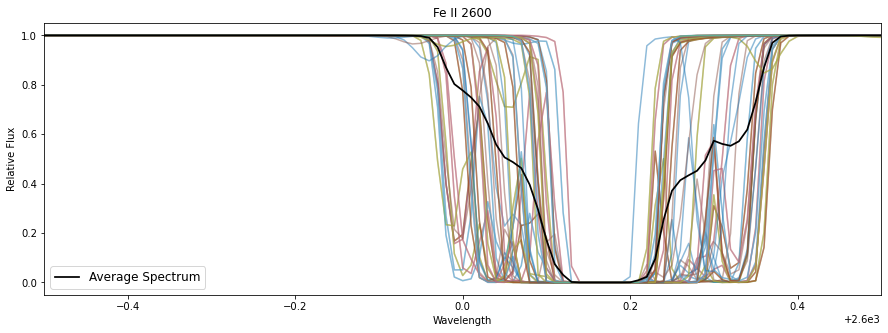

In [45]:
fe26_b = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
                  'Fe II 2600', 'Fe', 'II', 2599.5, 2600.5, 2600.17, 2.37E+08, 2.4E-01, 55.85,
                  DIY=True, ind_p=True)

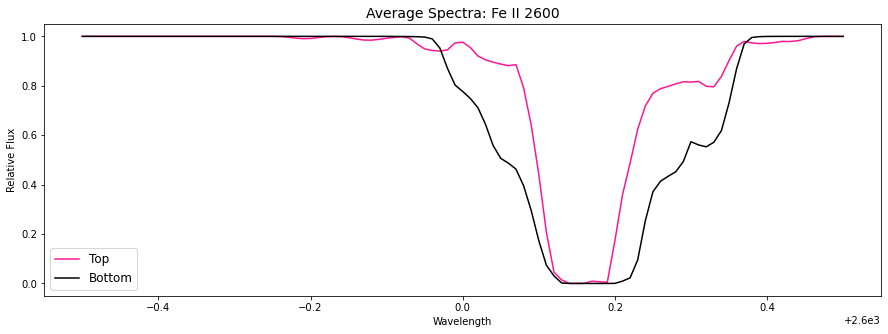

In [46]:
compare(fe26_t[0], fe26_t[1], fe26_b[0], fe26_b[1], ' Fe II 2600')

## Mg II 2796

yt : [INFO     ] 2021-11-29 15:26:55,443 Getting segment at z = 0.0: [0.0545 0.309  0.245 ] unitary to [0.0545 0.34   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:26:55,447 Getting subsegment: [0.0545 unitary, 0.309 unitary, 0.245 unitary] to [0.0545 unitary, 0.34 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:26:56,718 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:26:56,863 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:26:56,864 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:26:56,865 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:26:56,866 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     

yt : [INFO     ] 2021-11-29 15:27:05,229 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:27:05,230 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:27:05,230 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:27:05,232 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:27:05,249 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:27:05,256 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:27:05,410 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:27:05,416 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1360.88it/s]
yt : [INFO     ] 2021-11-29 15:27:05,487 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:27:05,503 Getting segment at z = 0.0: [0.05645312 0.309      

yt : [INFO     ] 2021-11-29 15:27:13,916 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1004.35it/s]
yt : [INFO     ] 2021-11-29 15:27:14,005 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:27:14,023 Getting segment at z = 0.0: [0.05840625 0.309      0.24695313] unitary to [0.05840625 0.34       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:27:14,026 Getting subsegment: [0.05840625000000001 unitary, 0.309 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.34 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:27:15,275 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:27:15,447 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:27:15,448 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:27:15,448 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-1

yt : [INFO     ] 2021-11-29 15:27:23,908 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:27:24,043 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:27:24,043 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:27:24,044 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:27:24,045 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:27:24,046 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:27:24,049 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:27:24,067 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:27:24,074 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:27:24,238 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:27:24,244 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:27:33,363 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:27:33,371 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:27:33,595 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:27:33,602 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 571.70it/s]
yt : [INFO     ] 2021-11-29 15:27:33,709 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:27:33,730 Getting segment at z = 0.0: [0.0623125  0.309      0.24890625] unitary to [0.0623125  0.34       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:27:33,732 Getting subsegment: [0.0623125 unitary, 0.309 unitary, 0.24890625 unitary] to [0.0623125 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:27:35,130 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:27:35,297 Parameters: current_t

yt : [INFO     ] 2021-11-29 15:27:42,776 Getting subsegment: [0.06426562499999999 unitary, 0.309 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.34 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:27:44,202 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:27:44,416 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:27:44,417 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:27:44,418 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:27:44,419 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:27:44,420 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:27:44,423 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:27:44,450 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:27:44,460 Identified 

yt : [INFO     ] 2021-11-29 15:27:53,332 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:27:53,332 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:27:53,335 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:27:53,352 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:27:53,359 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:27:53,523 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:27:53,531 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 858.33it/s]
yt : [INFO     ] 2021-11-29 15:27:53,608 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:27:53,621 Getting segment at z = 0.0: [0.06621875 0.309      0.25085937] unitary to [0.06621875 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:27:53,6

Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 492.28it/s]
yt : [INFO     ] 2021-11-29 15:28:02,252 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:28:02,274 Getting segment at z = 0.0: [0.06817188 0.309      0.25085937] unitary to [0.06817188 0.34       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:28:02,277 Getting subsegment: [0.068171875 unitary, 0.309 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.34 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:28:03,595 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:28:03,760 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:28:03,761 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:28:03,762 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:28:03,763 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] co

yt : [INFO     ] 2021-11-29 15:28:12,533 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:28:12,534 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:28:12,535 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:28:12,536 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:28:12,538 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:28:12,540 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:28:12,555 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:28:12,564 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:28:12,727 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:28:12,732 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 827.

yt : [INFO     ] 2021-11-29 15:28:21,258 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:28:21,266 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:28:21,424 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:28:21,430 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1080.27it/s]
yt : [INFO     ] 2021-11-29 15:28:21,502 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:28:21,517 Getting segment at z = 0.0: [0.07207812 0.309      0.2528125 ] unitary to [0.07207812 0.34       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:28:21,519 Getting subsegment: [0.07207812499999999 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07207812499999999 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:28:22,741 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:28:22,872 Pa

yt : [INFO     ] 2021-11-29 15:28:29,723 Getting subsegment: [0.07403125 unitary, 0.309 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.34 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:28:30,944 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:28:31,073 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:28:31,074 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:28:31,075 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:28:31,076 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:28:31,077 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:28:31,079 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:28:31,095 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:28:31,102 Identified 2.500e+01 octs
yt : 

yt : [INFO     ] 2021-11-29 15:28:39,658 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:28:39,660 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:28:39,676 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:28:39,682 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 15:28:39,837 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:28:39,842 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1465.39it/s]
yt : [INFO     ] 2021-11-29 15:28:39,913 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:28:39,927 Getting segment at z = 0.0: [0.0779375 0.309     0.245    ] unitary to [0.0779375 0.34      0.245    ] unitary.
yt : [INFO     ] 2021-11-29 15:28:39,930 Getting subsegment: [0.07793749999999999 unitary, 0.309 unitary, 0.245 unitary] to [0.07793749999999999 unitary, 0.34 unitary, 

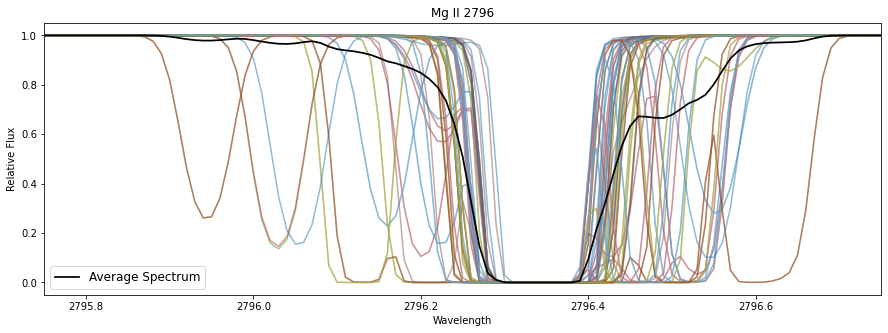

In [47]:
mg27_t = spec_avg(0.109,.618,.49,0.109,.68,.49, 14, 5,
                  'Mg II 2796', 'Mg', 'II', 2795.75, 2796.75, 2796.35, 2.68E+08, 6.29E-01, 24.31,
                  DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-29 15:28:56,955 Getting segment at z = 0.0: [0.0545 0.135  0.245 ] unitary to [0.0545 0.22   0.245 ] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 15:28:56,957 Getting subsegment: [0.0545 unitary, 0.135 unitary, 0.245 unitary] to [0.0545 unitary, 0.22000000000000003 unitary, 0.245 unitary].
yt : [INFO     ] 2021-11-29 15:28:58,203 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:28:58,346 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:28:58,347 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:28:58,348 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:28:58,349 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length


yt : [INFO     ] 2021-11-29 15:29:06,878 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:29:06,879 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:29:06,880 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:29:06,880 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:29:06,883 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:29:06,903 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:29:06,911 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:29:07,062 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:29:07,068 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1404.95it/s]
yt : [INFO     ] 2021-11-29 15:29:07,160 Writing spectrum to ascii file: spec.txt.
yt 

yt : [INFO     ] 2021-11-29 15:29:15,305 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:29:15,459 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:29:15,464 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1374.82it/s]
yt : [INFO     ] 2021-11-29 15:29:15,554 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:29:15,569 Getting segment at z = 0.0: [0.05840625 0.135      0.24695313] unitary to [0.05840625 0.22       0.24695313] unitary.
yt : [INFO     ] 2021-11-29 15:29:15,571 Getting subsegment: [0.05840625000000001 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.05840625000000001 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:29:16,824 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:29:16,963 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 

yt : [INFO     ] 2021-11-29 15:29:25,088 Getting subsegment: [0.060359375 unitary, 0.135 unitary, 0.24695312500000002 unitary] to [0.060359375 unitary, 0.22000000000000003 unitary, 0.24695312500000002 unitary].
yt : [INFO     ] 2021-11-29 15:29:26,310 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:29:26,502 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:29:26,503 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:29:26,504 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:29:26,505 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:29:26,506 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:29:26,509 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:29:26,534 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:29:2

yt : [INFO     ] 2021-11-29 15:29:36,802 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:29:36,803 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:29:36,806 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:29:36,829 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:29:36,836 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:29:37,053 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:29:37,059 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 930.59it/s]
yt : [INFO     ] 2021-11-29 15:29:37,171 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:29:37,188 Getting segment at z = 0.0: [0.0623125  0.135      0.24890625] unitary to [0.0623125  0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:29:37,1

yt : [INFO     ] 2021-11-29 15:29:46,239 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1096.14it/s]
yt : [INFO     ] 2021-11-29 15:29:46,338 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:29:46,356 Getting segment at z = 0.0: [0.06426562 0.135      0.24890625] unitary to [0.06426562 0.22       0.24890625] unitary.
yt : [INFO     ] 2021-11-29 15:29:46,358 Getting subsegment: [0.06426562499999999 unitary, 0.135 unitary, 0.24890625 unitary] to [0.06426562499999999 unitary, 0.22000000000000003 unitary, 0.24890625 unitary].
yt : [INFO     ] 2021-11-29 15:29:47,620 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:29:47,762 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:29:47,763 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:29:47,763 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-2

yt : [INFO     ] 2021-11-29 15:29:57,198 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:29:57,333 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:29:57,334 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:29:57,334 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:29:57,335 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:29:57,336 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:29:57,339 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:29:57,355 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:29:57,363 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:29:57,525 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:29:57,531 Creating spectrum
Add

yt : [INFO     ] 2021-11-29 15:30:05,975 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:30:05,992 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:30:05,999 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:30:06,157 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:30:06,163 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 932.03it/s]
yt : [INFO     ] 2021-11-29 15:30:06,274 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:30:06,568 Getting segment at z = 0.0: [0.06817188 0.135      0.25085937] unitary to [0.06817188 0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:30:06,570 Getting subsegment: [0.068171875 unitary, 0.135 unitary, 0.250859375 unitary] to [0.068171875 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:30:07,845 Saving field

yt : [INFO     ] 2021-11-29 15:30:15,206 Getting segment at z = 0.0: [0.070125   0.135      0.25085937] unitary to [0.070125   0.22       0.25085937] unitary.
yt : [INFO     ] 2021-11-29 15:30:15,208 Getting subsegment: [0.07012499999999999 unitary, 0.135 unitary, 0.250859375 unitary] to [0.07012499999999999 unitary, 0.22000000000000003 unitary, 0.250859375 unitary].
yt : [INFO     ] 2021-11-29 15:30:16,478 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:30:16,622 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:30:16,623 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:30:16,624 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:30:16,625 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:30:16,626 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:30:16,629 Setting i

yt : [INFO     ] 2021-11-29 15:30:25,223 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:30:25,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:30:25,225 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:30:25,226 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:30:25,229 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:30:25,246 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:30:25,252 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:30:25,409 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:30:25,414 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 919.12it/s]
yt : [INFO     ] 2021-11-29 15:30:25,524 Writing spectrum to ascii file: spec.txt.
yt :

yt : [INFO     ] 2021-11-29 15:30:34,104 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:30:34,263 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:30:34,269 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 873.26it/s]
yt : [INFO     ] 2021-11-29 15:30:34,387 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:30:34,405 Getting segment at z = 0.0: [0.07403125 0.135      0.2528125 ] unitary to [0.07403125 0.22       0.2528125 ] unitary.
yt : [INFO     ] 2021-11-29 15:30:34,407 Getting subsegment: [0.07403125 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07403125 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:30:35,647 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:30:35,783 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:30:35,783 Parameters: dom

yt : [INFO     ] 2021-11-29 15:30:42,909 Getting subsegment: [0.07598437499999999 unitary, 0.135 unitary, 0.2528125 unitary] to [0.07598437499999999 unitary, 0.22000000000000003 unitary, 0.2528125 unitary].
yt : [INFO     ] 2021-11-29 15:30:44,156 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 15:30:44,292 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 15:30:44,293 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 15:30:44,294 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 15:30:44,295 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:30:44,296 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:30:44,299 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:30:44,321 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:30:44,33

yt : [INFO     ] 2021-11-29 15:30:53,156 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 15:30:53,157 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 15:30:53,160 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 15:30:53,176 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 15:30:53,186 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 15:30:53,358 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 15:30:53,366 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1463.05it/s]
yt : [INFO     ] 2021-11-29 15:30:53,457 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 15:30:53,472 Getting segment at z = 0.0: [0.07989063 0.135      0.245     ] unitary to [0.07989063 0.22       0.245     ] unitary.
yt : [INFO     ] 2021-11-29 15:30:53,

yt : [INFO     ] 2021-11-29 15:31:02,037 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 909.54it/s]
yt : [INFO     ] 2021-11-29 15:31:02,169 Writing spectrum to ascii file: spec.txt.


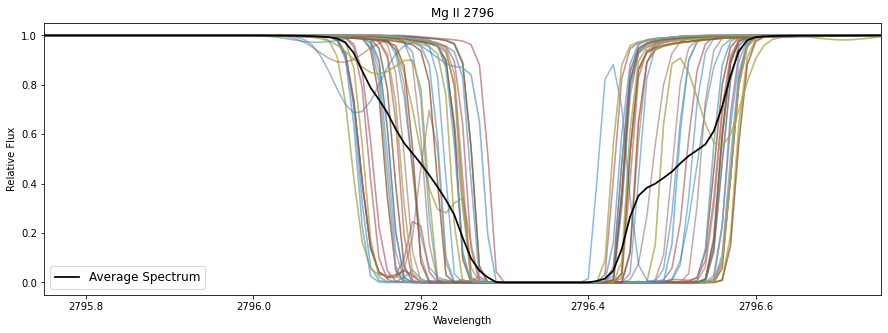

In [48]:
mg27_b = spec_avg(0.109,.27,.49,0.109,.44,.49, 14, 5,
                  'Mg II 2796', 'Mg', 'II', 2795.75, 2796.75, 2796.35, 2.68E+08, 6.29E-01, 24.31,
                  DIY=True, ind_p=True)

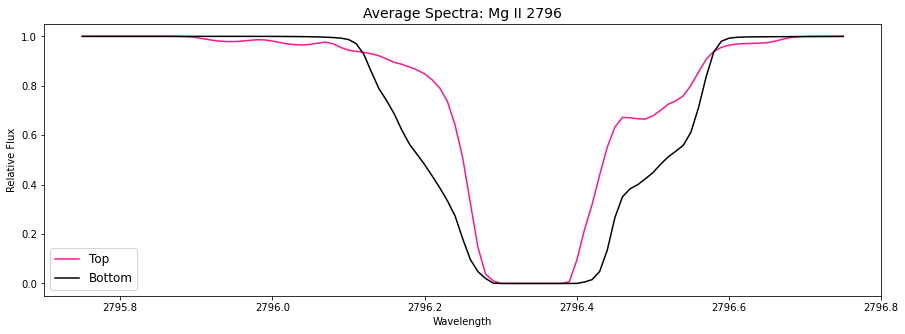

In [49]:
compare(mg27_t[0], mg27_t[1], mg27_b[0], mg27_b[1], ' Mg II 2796')